# Part I - Registered Voter Participation in Union County, NC

## Merge, Scrub, and Initial Exploration of Voter Registration and History Data

<font size=4rem>
    
- **[Introduction](#Introduction)<br>**

- **[Obtain](#Obtain)**<br>

- **[Scrub and Explore](#scrub_explore)**<br>

    - **[Voter Registration and History](#vote_reg_his)**<br>

    - **[Major Elections](#maj_elec)**<br>

</font>

# Introduction

The 2020 general election saw many key <a href="https://www.cnn.com/election/2020/results/president"> battleground states</a> battleground states with extremely close margins for not only the presidential race, but for races at virtually every level of the ballot. This resulted in recounts in several states and Senate runoff elections in Georgia. We also witnessed the <a href="https://www.washingtonpost.com/graphics/2020/elections/voter-turnout/">highest voter turnout in over a century</a>, with 2/3 of every American elligible to vote casting a ballot.

Many of the battleground states flipped from red to blue during the 2020 election in the midst of this massive voter turnout. However, my home state of North Carolina was not one of them. The 2020 election saw above average <a href="https://www.statista.com/statistics/1184621/presidential-election-voter-turnout-rate-state/"> voter turnout in NC</a> as compared to the country as a whole, with 71.5% of elligible North Carolinians showing up at the polls. In the last 3 presidential elections, North Carolina has made the list of <a href="https://www.cnn.com/2020/11/09/politics/2020-election-trump-biden-closest-states/index.html"> top 10 states</a> with the closest margin. This was also reflected at the state level in 2020, with one <a href="https://ballotpedia.org/North_Carolina_Supreme_Court_elections,_2020"> NC Supreme Court race</a> being decided by a margin of just 412 votes after a recount. When political races are as close as we saw in the 2020 general election, absolutely every vote counts. Thus, it is important to understand who is voting, and who is failing to turnout to the polls.

This project focuses on examining trends in voter turnout in the 2012, 2016, and 2020 elections in Union County, NC. I intend to scale up to examining statewide trends once finalized voter history records have been released for the 2020 general election for every county. I combined information from NC voter registration records with records of each registered individual's voting history, and built models to predict whether or not an individual participated (Vote vs. No Vote) and what voting method they used (Early, Election Day, or No Vote), with separate models for each year. 

Across all years, it was relatively difficult to predict a voter's participation in Union County based solely on the demographic information included in voter registration records. Binary (Vote vs. No Vote) model performance tended to max out at around 67% overall accuracy, with better performance correctly classifying people who did cast a ballot. Multiclass (Early, Election Day, No Vote) model performance tended to max out at around 50% overall accuracy. Interpretation of each model and a comparison of general elections by year for Union County can be found in <a href="https://github.com/zero731/NC_Elections_Capstone/blob/main/Final_Part_III_Model_Interpret_UC_Elecs.ipynb"> Part III</a> Part III of this project. Additionally, as part of this project, I created an interactive dashboard to help visualize trends in voter participation and demographics in Union County, NC. I will post the link here when it has been launched.

# Obtain

The data used for this project were obtained from the North Carolina State Board of Elections (NCSBE). Both <a href="https://www.ncsbe.gov/results-data/voter-registration-data"> voter registration records</a> and <a href="https://www.ncsbe.gov/results-data/voter-history-data"> voter history records</a> are made available and updated weekly. Voter history records do not contain demographic information, but the two files can be merged according to a unique ID (`ncid`) assigned to each registered voter in the state of North Carolina.

In this notebook, I merged the two files (data used for the current version of this project obtained from the NCSBE site on January 4, 2021) to obtain a single dataframe containing both demographic and vote history information for each registered voter in Union County. To see an explanation of my next major steps in cleaning and preparing the data for visualizing and modeling, see the beginning of the [Scrub and Explore](#scrub_explore) section of this notebook. Some of the steps taken were necessary, but somewhat limit the scope of how the models can be applied and how trends should be interpreted.

In [1]:
## Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

## Import functions made specifically for this project
from capstone_functions import *

In [2]:
## Set options for displaying Pandas DataFrames
pd.options.display.max_columns = 100
pd.options.display.max_rows = 120

In [3]:
## Load in voter registration data for Union County
uc_vreg = pd.read_table('Data/ncvoter90_Jan4.zip', encoding='ISO-8859-1')
uc_vreg.head()

county_id county_desc  voter_reg_num status_cd voter_status_desc reason_cd  \
0         90       UNION         346446         A            ACTIVE        AV   
1         90       UNION         348004         A            ACTIVE        AV   
2         90       UNION         281016         A            ACTIVE        AV   
3         90       UNION         288489         A            ACTIVE        AV   
4         90       UNION         279308         A            ACTIVE        AV   

  voter_status_reason_desc absent_ind name_prefx_cd last_name first_name  \
0                 VERIFIED                             AALAEI       ARIO   
1                 VERIFIED                             AALAEI    KAVITHA   
2                 VERIFIED                            AALBORG     ALEXIS   
3                 VERIFIED                            AALBORG      BRYAN   
4                 VERIFIED                            AALBORG     SHARON   

    middle_name name_suffix_lbl         res_street_address res_city_desc  \
0           NaN             NaN   4009  MILLBRIDGE PKWY           WAXHAW   
1           NaN             NaN   4009  MILLBRIDGE PKWY           WAXHAW   
2         LEANN             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   
3           LEE             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   
4  SCHLEENBAKER             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   

  state_cd  zip_code             mail_addr1 mail_addr2 mail_addr3 mail_addr4  \
0       NC   28173.0   4009 MILLBRIDGE PKWY        NaN        NaN        NaN   
1       NC   28173.0   4009 MILLBRIDGE PKWY        NaN        NaN        NaN   
2       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   
3       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   
4       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   

      mail_city mail_state mail_zipcode  full_phone_number race_code  \
0        WAXHAW         NC        28173                NaN         W   
1        WAXHAW         NC        28173                NaN         A   
2  INDIAN TRAIL         NC        28079                NaN         W   
3  INDIAN TRAIL         NC        28079                NaN         W   
4  INDIAN TRAIL         NC        28079                NaN         W   

  ethnic_code party_cd gender_code  birth_age birth_state drivers_lic  \
0          NL      UNA           M         47          OC           Y   
1          NL      DEM           F         47          OC           Y   
2          NL      UNA           F         27          IA           Y   
3          UN      UNA           M         63          OK           Y   
4          NL      REP           F         63          PA           Y   

   registr_dt precinct_abbrv precinct_desc  municipality_abbrv  \
0  04/25/2019           020A          020A                 5.0   
1  06/24/2019           020A          020A                 5.0   
2  11/04/2013           029A          029A                 6.0   
3  09/17/2014           029A          029A                 6.0   
4  07/24/2013           029A          029A                 6.0   

  municipality_desc  ward_abbrv  ward_desc  cong_dist_abbrv super_court_abbrv  \
0            WAXHAW         NaN        NaN              9.0               20B   
1            WAXHAW         NaN        NaN              9.0               20B   
2      INDIAN TRAIL         NaN        NaN              9.0               20B   
3      INDIAN TRAIL         NaN        NaN              9.0               20B   
4      INDIAN TRAIL         NaN        NaN              9.0               20B   

  judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  county_commiss_abbrv  \
0              20C             35.0            68.0                   NaN   
1              20C             35.0            68.0                   NaN   
2              20C             35.0            68.0                   NaN   
3              20C             35.0            68.0      

In [4]:
## Load in voter history data for Union County
uc_vhis = pd.read_table('Data/ncvhis90_Jan4.zip')
uc_vhis.head()

county_id county_desc  voter_reg_num election_lbl       election_desc  \
0         90       UNION         285297   11/08/2016  11/08/2016 GENERAL   
1         90       UNION         285297   09/10/2019  09/10/2019 GENERAL   
2         90       UNION         285297   03/03/2020  03/03/2020 PRIMARY   
3         90       UNION         285297   11/06/2018  11/06/2018 GENERAL   
4         90       UNION         285297   11/03/2020  11/03/2020 GENERAL   

      voting_method voted_party_cd voted_party_desc pct_label pct_description  \
0  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   
1  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   
2         IN-PERSON            REP       REPUBLICAN       016             016   
3  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   
4  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   

       ncid  voted_county_id voted_county_desc vtd_label vtd_description  
0  AA100547               90             UNION       016             016  
1  AA100547               90             UNION       016             016  
2  AA100547               90             UNION       016             016  
3  AA100547               90             UNION       016             016  
4  AA100547               90             UNION       016             016

<a id='scrub_explore'></a>
# Scrub and Explore

The major steps I took in cleaning and preparing the data for modelling and visualizing were as follows:
1. **Drop duplicate records from both voter history records.** This included identical duplicates and records/ rows that were not completely identical, but shared the same combination of `ncid` (unique voter ID) and `election_desc` (the specific election for which the voter cast a ballot). Each `ncid` should only show up in a given election once, since each voter gets a single vote. To see the code and explanation for how this problem was handled, jump to [this section](#drop_dup).
2. **Drop voter registration records for individuals with "Removed" or "Denied" status.** These individuals are currently (as of January 4) inelligible to vote within Union County. Because the records do not indicate when their status was changed, I could not account for the fact that they may have been elligible to vote in either the 2012 or 2016 election. Thus the dataframes for those elections may be missing individuals who were elligible to vote then, but not in 2020.
3. **Merge cleaned voter history data onto cleaned voter registration data on `ncid`.**
4. **Create a separate dataframe for each election (general 2012, 2016, and 2020).** Individuals were excluded from an election dataframe for a given year if they were not registered in time to vote in that election, or if they were too young to vote that year. This left one record per elligible, registered individual in each dataset, even if they did not cast a vote in that particular year.

<a id='vote_reg_his'></a>
## Vote Registration and History

In [5]:
## Check metadata for voter registration dataframe
uc_vreg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185008 entries, 0 to 185007
Data columns (total 71 columns):
county_id                   185008 non-null int64
county_desc                 185008 non-null object
voter_reg_num               185008 non-null int64
status_cd                   185008 non-null object
voter_status_desc           185008 non-null object
reason_cd                   185008 non-null object
voter_status_reason_desc    185008 non-null object
absent_ind                  185008 non-null object
name_prefx_cd               185008 non-null object
last_name                   185004 non-null object
first_name                  185005 non-null object
middle_name                 169910 non-null object
name_suffix_lbl             21203 non-null object
res_street_address          185008 non-null object
res_city_desc               171451 non-null object
state_cd                    171451 non-null object
zip_code                    171451 non-null float64
mail_addr1              

In [6]:
## Check metadata for voter history dataframe
uc_vhis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807296 entries, 0 to 807295
Data columns (total 15 columns):
county_id            807296 non-null int64
county_desc          807296 non-null object
voter_reg_num        807296 non-null int64
election_lbl         807296 non-null object
election_desc        807296 non-null object
voting_method        807296 non-null object
voted_party_cd       807232 non-null object
voted_party_desc     807232 non-null object
pct_label            807296 non-null object
pct_description      807296 non-null object
ncid                 807296 non-null object
voted_county_id      807296 non-null int64
voted_county_desc    807296 non-null object
vtd_label            807118 non-null object
vtd_description      807118 non-null object
dtypes: int64(3), object(12)
memory usage: 92.4+ MB


### Explore Duplicate Records

In [7]:
## Check for duplicate entries in voter registration data
uc_vreg.duplicated().sum()

0

In [8]:
## Check for duplicate entries in voter history data
uc_vhis.duplicated().sum()

134

In [9]:
## Inspect duplicate entries in voter history data
exact_dup_vhis = uc_vhis.loc[uc_vhis.duplicated()]
exact_dup_vhis

county_id county_desc  voter_reg_num election_lbl  \
9068           90       UNION         325228   09/10/2019   
9069           90       UNION         325228   03/03/2020   
26484          90       UNION         205258   11/06/2012   
36111          90       UNION         338757   11/06/2018   
75412          90       UNION         204911   11/06/2012   
75414          90       UNION         204911   11/04/2014   
86295          90       UNION         222835   11/06/2012   
86296          90       UNION         222835   05/08/2012   
133106         90       UNION         312964   03/03/2020   
163993         90       UNION         178227   11/06/2012   
163994         90       UNION         178227   05/08/2012   
170052         90       UNION         179951   11/06/2012   
226704         90       UNION         196079   11/06/2012   
233972         90       UNION          17339   11/06/2012   
243106         90       UNION         200805   11/06/2012   
263992         90       UNION          18973   11/08/2011   
263993         90       UNION          18973   11/06/2012   
263994         90       UNION          18973   05/08/2012   
263995         90       UNION          18973   11/04/2014   
269252         90       UNION         209417   11/06/2012   
269253         90       UNION         209417   05/08/2012   
270148         90       UNION          19253   11/04/2014   
270149         90       UNION          19253   11/06/2012   
315682         90       UNION         227888   11/06/2012   
320878         90       UNION         230045   05/08/2012   
321313         90       UNION         230231   11/06/2012   
321314         90       UNION         230231   05/08/2012   
324097         90       UNION         231341   11/06/2012   
326611         90       UNION         232369   11/06/2012   
326612         90       UNION         232369   03/15/2016   
333665         90       UNION         235368   11/06/2012   
335949         90       UNION         236358   11/03/2020   
339064         90       UNION         237562   11/06/2012   
339956         90       UNION         237947   11/06/2012   
347603         90       UNION         241682   11/06/2012   
376311         90       UNION         254206   05/08/2012   
384195         90       UNION         257417   11/08/2011   
399138         90       UNION         287782   11/04/2014   
401072         90       UNION         265371   11/08/2016   
405801         90       UNION         267527   09/10/2019   
411739         90       UNION          28210   11/04/2014   
437046         90       UNION         339240   11/06/2018   
446006         90       UNION          30864   03/15/2016   
446007         90       UNION          30864   11/06/2012   
446008         90       UNION          30864   05/08/2012   
446009         90       UNION          30864   11/04/2014   
446010         90       UNION          30864   11/08/2011   
446011         90       UNION          30864   07/17/2012   
446012         90       UNION          30864   11/08/2016   
446013         90       UNION          30864   10/11/2011   
496539         90       UNION          67070   11/06/2012   
510427         90       UNION         328504   11/03/2020   
512626         90       UNION         329886   11/06/2018   
523650         90       UNION         338301   03/03/2020   
526312         90       UNION          92478   11/05/2013   
526313         90       UNION          92478   11/08/2016   
526314         90       UNION          92478   11/08/2011   
526315         90       UNION          92478   11/06/2012   
526316         90       UNION          92478   05/08/2012   
529480         90       UNION          92845   05/08/2012   
...           ...         ...            ...          ...   
600394         90       UNION         110907   11/04/2014   
600395         90       UNION         110907   11/06/2012   
600396         90       UNION         110907   03/15/2016   
600578         90       UNION         11099

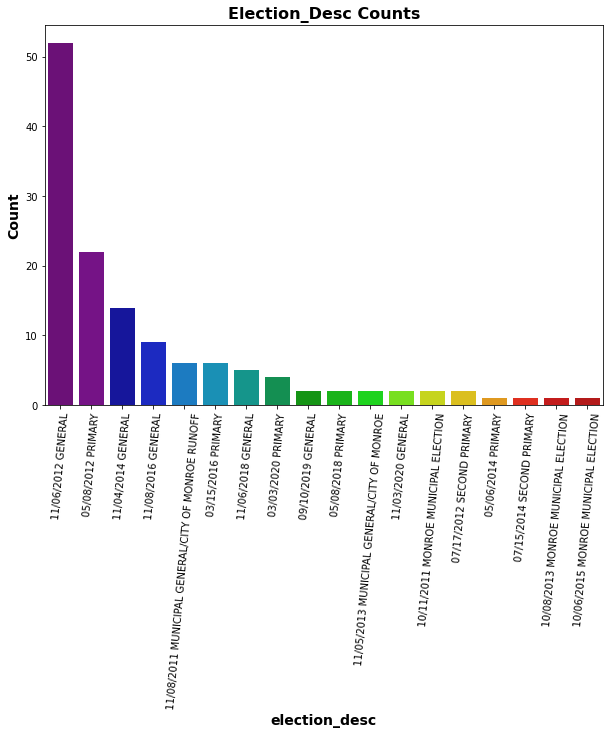

In [10]:
plot_count('election_desc', exact_dup_vhis, rotation=85);

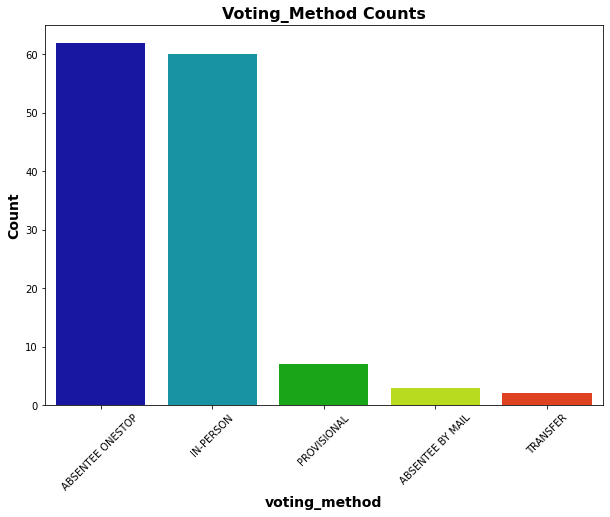

In [11]:
plot_count('voting_method', exact_dup_vhis, rotation=45);

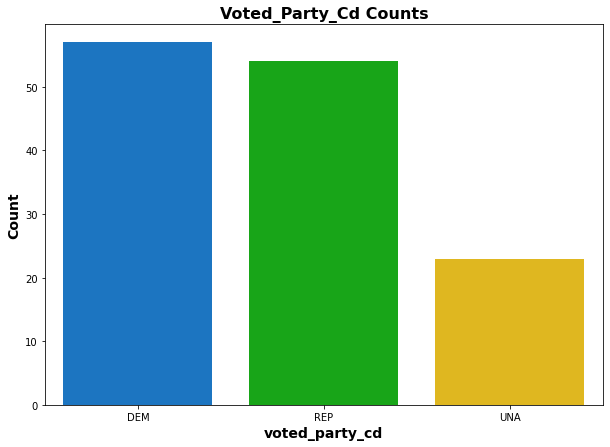

In [12]:
plot_count('voted_party_cd', exact_dup_vhis);

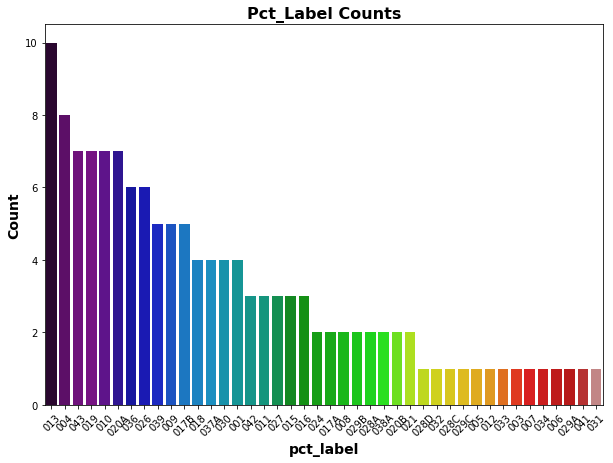

In [13]:
plot_count('pct_label', exact_dup_vhis, rotation=45);

In [14]:
## Remove exact duplicate entries from records of voter history
uc_vhis.drop_duplicates(inplace=True)

In [15]:
## There are 9 instances where an ncid shows up as casting a vote
  ## more than once in the same election where the records aren't exact copies
uc_vhis.duplicated(subset=['ncid','election_desc']).sum()

9

In [16]:
## A total of 7 individuals show up more than once for a single election
dup_ncid_elecs = uc_vhis.loc[uc_vhis.duplicated(subset=['ncid', 'election_desc'], keep=False)]
display(dup_ncid_elecs.head())
dup_ncid_elecs['ncid'].nunique()

county_id county_desc  voter_reg_num election_lbl       election_desc  \
31488          90       UNION         338735   11/06/2018  11/06/2018 GENERAL   
31492          90       UNION         338735   11/06/2018  11/06/2018 GENERAL   
149121         90       UNION         364740   11/08/2016  11/08/2016 GENERAL   
149122         90       UNION         364740   11/06/2012  11/06/2012 GENERAL   
149123         90       UNION         364740   03/15/2016  03/15/2016 PRIMARY   

           voting_method voted_party_cd voted_party_desc pct_label  \
31488        PROVISIONAL            REP       REPUBLICAN      020B   
31492          IN-PERSON            REP       REPUBLICAN       058   
149121  ABSENTEE ONESTOP            UNA     UNAFFILIATED       W16   
149122  ABSENTEE ONESTOP            UNA     UNAFFILIATED       W25   
149123  ABSENTEE ONESTOP            DEM       DEMOCRATIC       W16   

       pct_description       ncid  voted_county_id voted_county_desc  \
31488             020B  CW1012090               90             UNION   
31492          PCT 058  CW1012090               60       MECKLENBURG   
149121             W16   DB153036               65       NEW HANOVER   
149122             W25   DB153036               65       NEW HANOVER   
149123             W16   DB153036               65       NEW HANOVER   

       vtd_label vtd_description  
31488       020B            020B  
31492        058             058  
149121       W16             W16  
149122       W25             W25  
149123       W16             W16

7

In [17]:
## Examine the complete recent voting history of the 7 ncid's that show up 
  ## multiple times for a single election to investigate how the records differ
for ncid in dup_ncid_elecs['ncid'].unique():
    display(uc_vhis.loc[uc_vhis['ncid']==ncid].sort_values(['election_desc']))

county_id county_desc  voter_reg_num election_lbl  \
31487         90       UNION         338735   03/03/2020   
31490         90       UNION         338735   09/10/2019   
31495         90       UNION         338735   11/03/2015   
31489         90       UNION         338735   11/03/2020   
31494         90       UNION         338735   11/04/2014   
31491         90       UNION         338735   11/05/2019   
31488         90       UNION         338735   11/06/2018   
31492         90       UNION         338735   11/06/2018   
31493         90       UNION         338735   11/08/2016   

              election_desc     voting_method voted_party_cd voted_party_desc  \
31487    03/03/2020 PRIMARY  ABSENTEE ONESTOP            REP       REPUBLICAN   
31490    09/10/2019 GENERAL         IN-PERSON            REP       REPUBLICAN   
31495    11/03/2015 GENERAL         IN-PERSON            REP       REPUBLICAN   
31489    11/03/2020 GENERAL  ABSENTEE ONESTOP            REP       REPUBLICAN   
31494    11/04/2014 GENERAL         IN-PERSON            REP       REPUBLICAN   
31491  11/05/2019 MUNICIPAL         IN-PERSON            REP       REPUBLICAN   
31488    11/06/2018 GENERAL       PROVISIONAL            REP       REPUBLICAN   
31492    11/06/2018 GENERAL         IN-PERSON            REP       REPUBLICAN   
31493    11/08/2016 GENERAL         IN-PERSON            REP       REPUBLICAN   

      pct_label pct_description       ncid  voted_county_id voted_county_desc  \
31487      020B            020B  CW1012090               90             UNION   
31490      020B            020B  CW1012090               90             UNION   
31495       058         PCT 058  CW1012090               60       MECKLENBURG   
31489      020B            020B  CW1012090               90             UNION   
31494       148         PCT 148  CW1012090               60       MECKLENBURG   
31491      020B            020B  CW1012090               90             UNION   
31488      020B            020B  CW1012090               90             UNION   
31492       058         PCT 058  CW1012090               60       MECKLENBURG   
31493       058         PCT 058  CW1012090               60       MECKLENBURG   

      vtd_label vtd_description  
31487      020B            020B  
31490      020B            020B  
31495       058             058  
31489      020B            020B  
31494       148             148  
31491      020B            020B  
31488      020B            020B  
31492       058             058  
31493       058             058

county_id county_desc  voter_reg_num election_lbl       election_desc  \
149123         90       UNION         364740   03/15/2016  03/15/2016 PRIMARY   
149127         90       UNION         364740   03/15/2016  03/15/2016 PRIMARY   
149125         90       UNION         364740   05/08/2012  05/08/2012 PRIMARY   
149126         90       UNION         364740   11/03/2020  11/03/2020 GENERAL   
149120         90       UNION         364740   11/04/2014  11/04/2014 GENERAL   
149122         90       UNION         364740   11/06/2012  11/06/2012 GENERAL   
149128         90       UNION         364740   11/06/2012  11/06/2012 GENERAL   
149124         90       UNION         364740   11/06/2018  11/06/2018 GENERAL   
149121         90       UNION         364740   11/08/2016  11/08/2016 GENERAL   
149129         90       UNION         364740   11/08/2016  11/08/2016 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
149123  ABSENTEE ONESTOP            DEM       DEMOCRATIC       W16   
149127         IN-PERSON            REP       REPUBLICAN      0070   
149125         IN-PERSON            DEM       DEMOCRATIC       W25   
149126  ABSENTEE ONESTOP            REP       REPUBLICAN      020A   
149120  ABSENTEE ONESTOP            UNA     UNAFFILIATED       W16   
149122  ABSENTEE ONESTOP            UNA     UNAFFILIATED       W25   
149128  ABSENTEE ONESTOP            REP       REPUBLICAN      0070   
149124         IN-PERSON            UNA     UNAFFILIATED      CF02   
149121  ABSENTEE ONESTOP            UNA     UNAFFILIATED       W16   
149129  ABSENTEE ONESTOP            REP       REPUBLICAN      0070   

       pct_description      ncid  voted_county_id voted_county_desc vtd_label  \
149123             W16  DB153036               65       NEW HANOVER       W16   
149127           SALEM  DB153036               12             BURKE      0070   
149125             W25  DB153036               65       NEW HANOVER       W25   
149126            020A  DB153036               90             UNION      020A   
149120             W16  DB153036               65       NEW HANOVER       W16   
149122             W25  DB153036               65       NEW HANOVER       W25   
149128           SALEM  DB153036               12             BURKE      0070   
149124            CF02  DB153036               65       NEW HANOVER      CF02   
149121             W16  DB153036               65       NEW HANOVER       W16   
149129           SALEM  DB153036               12             BURKE      0070   

       vtd_description  
149123             W16  
149127            0070  
149125             W25  
149126            020A  
149120             W16  
149122             W25  
149128            0070  
149124            CF02  
149121             W16  
149129            0070

county_id county_desc  voter_reg_num election_lbl  \
371877         90       UNION         252400   03/03/2020   
371873         90       UNION         252400   03/15/2016   
371871         90       UNION         252400   05/08/2012   
371879         90       UNION         252400   09/10/2019   
371875         90       UNION         252400   11/03/2020   
371876         90       UNION         252400   11/04/2014   
371878         90       UNION         252400   11/05/2019   
371870         90       UNION         252400   11/06/2012   
371874         90       UNION         252400   11/06/2018   
371872         90       UNION         252400   11/07/2017   
371880         90       UNION         252400   11/08/2011   
371869         90       UNION         252400   11/08/2016   
371881         90       UNION         252400   11/08/2016   

                                            election_desc     voting_method  \
371877                                 03/03/2020 PRIMARY         IN-PERSON   
371873                                 03/15/2016 PRIMARY         IN-PERSON   
371871                                 05/08/2012 PRIMARY         IN-PERSON   
371879                                 09/10/2019 GENERAL         IN-PERSON   
371875                                 11/03/2020 GENERAL  ABSENTEE ONESTOP   
371876                                 11/04/2014 GENERAL         IN-PERSON   
371878                               11/05/2019 MUNICIPAL         IN-PERSON   
371870                                 11/06/2012 GENERAL         IN-PERSON   
371874                                 11/06/2018 GENERAL         IN-PERSON   
371872                               11/07/2017 MUNICIPAL         IN-PERSON   
371880  11/08/2011 MUNICIPAL GENERAL/CITY OF MONROE RU...         IN-PERSON   
371869                                 11/08/2016 GENERAL         IN-PERSON   
371881                                 11/08/2016 GENERAL  ABSENTEE ONESTOP   

       voted_party_cd voted_party_desc pct_label pct_description      ncid  \
371877            DEM       DEMOCRATIC      028D            028D  EF164225   
371873            DEM       DEMOCRATIC      028D            028D  EF164225   
371871            DEM       DEMOCRATIC      028D            028D  EF164225   
371879            DEM       DEMOCRATIC      028D            028D  EF164225   
371875            DEM       DEMOCRATIC      028D            028D  EF164225   
371876            DEM       DEMOCRATIC      028D            028D  EF164225   
371878            DEM       DEMOCRATIC      028D            028D  EF164225   
371870            DEM       DEMOCRATIC      028D            028D  EF164225   
371874            DEM       DEMOCRATIC      028D            028D  EF164225   
371872            DEM       DEMOCRATIC      028D            028D  EF164225   
371880            DEM       DEMOCRATIC      028D            028D  EF164225   
371869            DEM       DEMOCRATIC      028D            028D  EF164225   
371881            REP       REPUBLICAN       022         PCT 022  EF164225   

        voted_county_id voted_county_desc vtd_label vtd_description  
371877               90             UNION       028             028  
371873               90             UNION       028             028  
371871               90             UNION       028             028  
371879               90             UNION       028             028  
371875               90             UNION       028             028  
371876               90             UNION       028             028  
371878               90             UNION       028             028  
371870               90             UNION       028             028  
371874               90             UNION       028             028  
371872               90             UNION       028             028  
371880               90             UNION       028             028  
371869               90             UNION       028             028  
371881               60       MECKLENBURG  

county_id county_desc  voter_reg_num election_lbl       election_desc  \
435242         90       UNION         307237   11/03/2020  11/03/2020 GENERAL   
435239         90       UNION         307237   11/04/2014  11/04/2014 GENERAL   
435240         90       UNION         307237   11/06/2012  11/06/2012 GENERAL   
435243         90       UNION         307237   11/06/2012  11/06/2012 GENERAL   
435241         90       UNION         307237   11/08/2016  11/08/2016 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
435242         IN-PERSON            REP       REPUBLICAN       013   
435239         IN-PERSON            REP       REPUBLICAN      038A   
435240         IN-PERSON            REP       REPUBLICAN      038A   
435243  ABSENTEE ONESTOP            UNA     UNAFFILIATED       CUL   
435241         IN-PERSON            REP       REPUBLICAN       039   

       pct_description      ncid  voted_county_id voted_county_desc vtd_label  \
435242             013  EF186914               90             UNION       013   
435239            038A  EF186914               90             UNION      038A   
435240            038A  EF186914               90             UNION      038A   
435243       CULLOWHEE  EF186914               50           JACKSON       CUL   
435241             039  EF186914               90             UNION       039   

       vtd_description  
435242             013  
435239            038A  
435240            038A  
435243             CUL  
435241             039

county_id county_desc  voter_reg_num election_lbl       election_desc  \
698002         90       UNION         144979   03/03/2020  03/03/2020 PRIMARY   
698003         90       UNION         144979   09/10/2019  09/10/2019 GENERAL   
698006         90       UNION         144979   11/03/2020  11/03/2020 GENERAL   
698004         90       UNION         144979   11/06/2012  11/06/2012 GENERAL   
698007         90       UNION         144979   11/06/2012  11/06/2012 GENERAL   
698005         90       UNION         144979   11/06/2018  11/06/2018 GENERAL   
698001         90       UNION         144979   11/08/2016  11/08/2016 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
698002  ABSENTEE ONESTOP            REP       REPUBLICAN       039   
698003         IN-PERSON            REP       REPUBLICAN       039   
698006  ABSENTEE ONESTOP            REP       REPUBLICAN       039   
698004         IN-PERSON            REP       REPUBLICAN       039   
698007         IN-PERSON            REP       REPUBLICAN       039   
698005         IN-PERSON            REP       REPUBLICAN       039   
698001  ABSENTEE ONESTOP            REP       REPUBLICAN       039   

       pct_description     ncid  voted_county_id voted_county_desc vtd_label  \
698002             039  EF69085               90             UNION       039   
698003             039  EF69085               90             UNION       039   
698006             039  EF69085               90             UNION       039   
698004             039  EF69085               90             UNION      038A   
698007             039  EF69085               90             UNION       039   
698005             039  EF69085               90             UNION       039   
698001             039  EF69085               90             UNION       039   

       vtd_description  
698002             039  
698003             039  
698006             039  
698004            038A  
698007             039  
698005             039  
698001             039

county_id county_desc  voter_reg_num election_lbl       election_desc  \
728804         90       UNION         341724   11/03/2020  11/03/2020 GENERAL   
728803         90       UNION         341724   11/08/2016  11/08/2016 GENERAL   
728805         90       UNION         341724   11/08/2016  11/08/2016 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
728804  ABSENTEE ONESTOP            REP       REPUBLICAN      038A   
728803  ABSENTEE ONESTOP            REP       REPUBLICAN      029A   
728805  ABSENTEE ONESTOP            REP       REPUBLICAN     11-01   

       pct_description     ncid  voted_county_id voted_county_desc vtd_label  \
728804            038A  EF78820               90             UNION      038A   
728803            029A  EF78820               90             UNION      029A   
728805           11-01  EF78820               13          CABARRUS     11-01   

       vtd_description  
728804            038A  
728803            029A  
728805           11-01

county_id county_desc  voter_reg_num election_lbl       election_desc  \
777893         90       UNION         272193   11/06/2012  11/06/2012 GENERAL   
777894         90       UNION         272193   11/06/2012  11/06/2012 GENERAL   

           voting_method voted_party_cd voted_party_desc pct_label  \
777893         IN-PERSON            DEM       DEMOCRATIC      BURN   
777894  ABSENTEE ONESTOP            DEM       DEMOCRATIC       009   

       pct_description     ncid  voted_county_id voted_county_desc vtd_label  \
777893      BURNSVILLE  EF93894                4             ANSON      BURN   
777894             009  EF93894               90             UNION       009   

       vtd_description  
777893            BURN  
777894             009

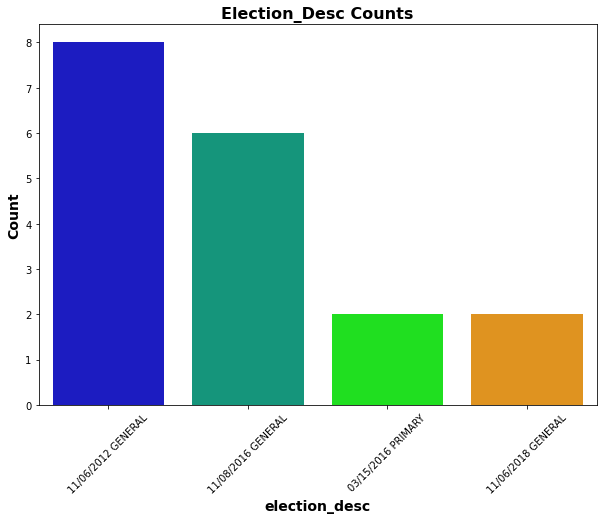

In [18]:
plot_count('election_desc', dup_ncid_elecs, rotation=45);

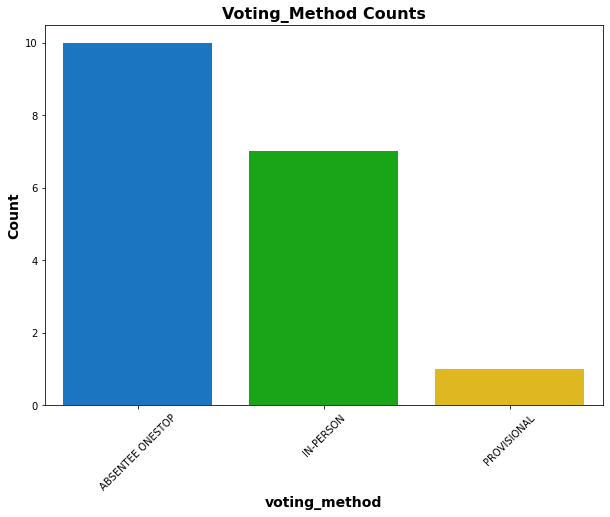

In [19]:
plot_count('voting_method', dup_ncid_elecs, rotation=45);

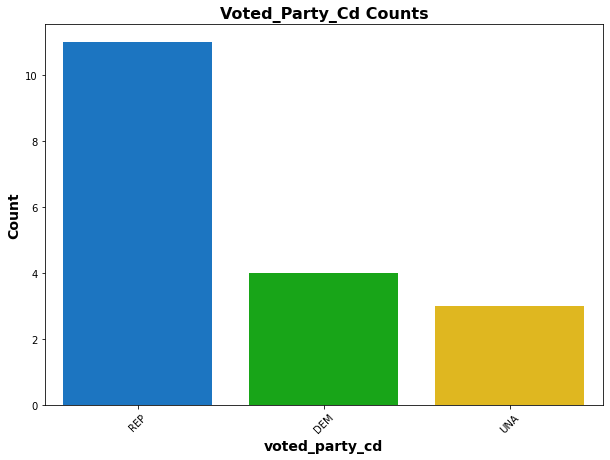

In [20]:
plot_count('voted_party_cd', dup_ncid_elecs, rotation=45);

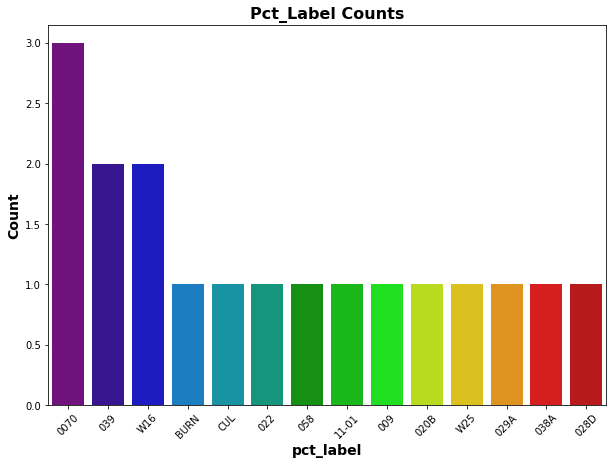

In [21]:
plot_count('pct_label', dup_ncid_elecs, rotation=45);

### Explore Voter Registration Records

In [22]:
## Check number of unique individuals represented in voter reg records
uc_vreg['ncid'].nunique()

185008

In [23]:
## Check voter status information -- Should any categories be removed??
uc_vreg['voter_status_desc'].value_counts()

ACTIVE       155227
INACTIVE      14748
REMOVED       13554
DENIED         1356
TEMPORARY       123
Name: voter_status_desc, dtype: int64

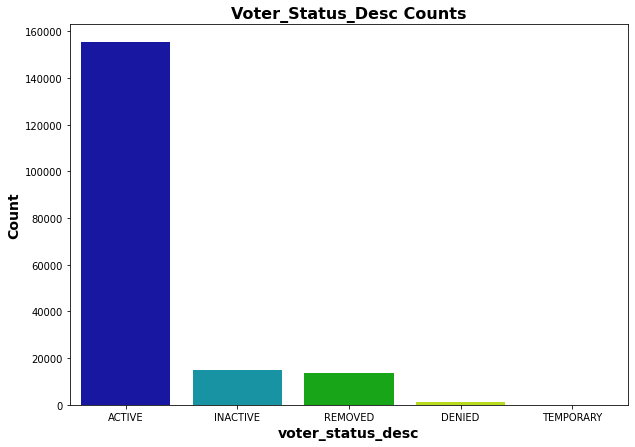

In [24]:
plot_count('voter_status_desc', uc_vreg);

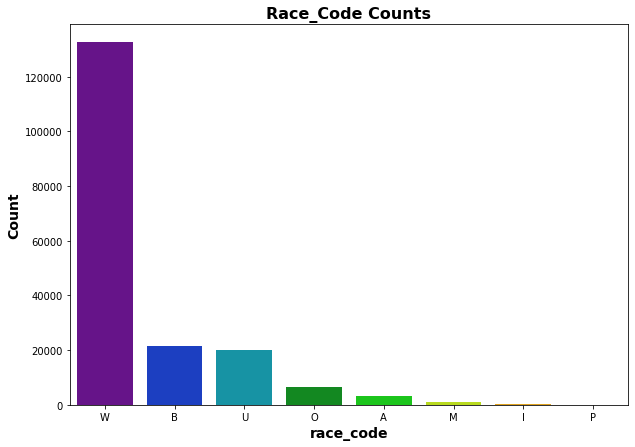

In [25]:
plot_count('race_code', uc_vreg);

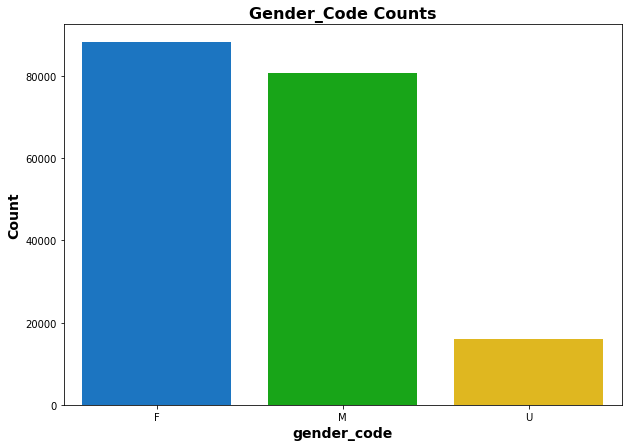

In [26]:
plot_count('gender_code', uc_vreg);

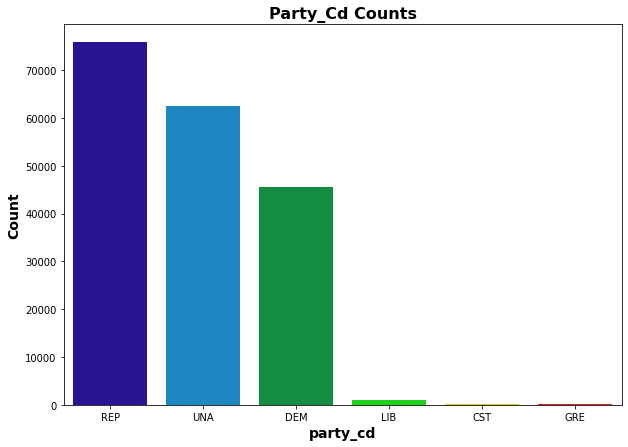

In [27]:
plot_count('party_cd', uc_vreg); # registered party

In [28]:
uc_vreg['birth_year'].min()

1907

In [29]:
uc_vreg['birth_year'].sort_values()[:10]

1488      1907
176595    1910
154566    1912
157817    1912
65965     1912
70429     1912
55363     1913
55299     1913
111685    1913
149172    1913
Name: birth_year, dtype: int64

Text(0, 0.5, 'Count')

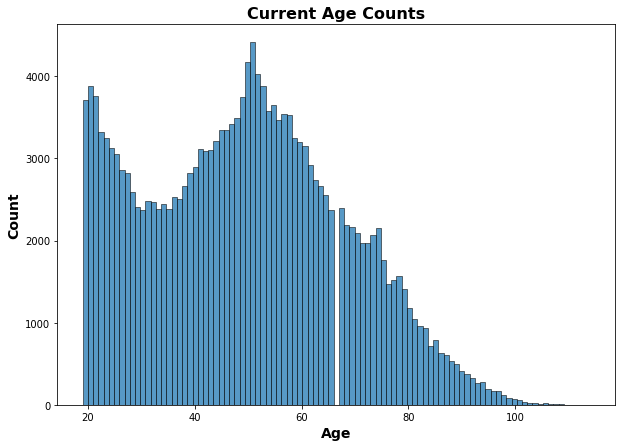

In [30]:
## Plot distribution of current age as of EOY 2020 
  ## Note that the birth_age column in uc_vreg is specific to the date that
    ## individual registered to vote, so not reflective of current age
plt.figure(figsize=(10,7))
ax = sns.histplot(uc_vreg['birth_age'])
ax.set_title('Current Age Counts', fontsize=16, weight='bold')
ax.set_xlabel('Age', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=14, weight='bold')

In [31]:
uc_vreg.loc[uc_vreg['birth_state']=='NO']

county_id county_desc  voter_reg_num status_cd voter_status_desc  \
76417         90       UNION         260882         A            ACTIVE   

      reason_cd voter_status_reason_desc absent_ind name_prefx_cd   last_name  \
76417        AV                 VERIFIED                           HOLSHOUSER   

      first_name middle_name name_suffix_lbl res_street_address res_city_desc  \
76417     HUNTER       SCOTT             NaN  517 W BRIEF RD     INDIAN TRAIL   

      state_cd  zip_code      mail_addr1 mail_addr2 mail_addr3 mail_addr4  \
76417       NC   28079.0  517 W BRIEF RD        NaN        NaN        NaN   

          mail_city mail_state mail_zipcode  full_phone_number race_code  \
76417  INDIAN TRAIL         NC        28079                NaN         W   

      ethnic_code party_cd gender_code  birth_age birth_state drivers_lic  \
76417          NL      REP           M         27          NO           Y   

       registr_dt precinct_abbrv precinct_desc  municipality_abbrv  \
76417  05/18/2010            032           032                93.0   

      municipality_desc  ward_abbrv  ward_desc  cong_dist_abbrv  \
76417          FAIRVIEW         NaN        NaN              9.0   

      super_court_abbrv judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  \
76417               20B              20C             36.0            69.0   

       county_commiss_abbrv  county_commiss_desc  township_abbrv  \
76417                   NaN                  NaN             NaN   

       township_desc  school_dist_abbrv school_dist_desc  fire_dist_abbrv  \
76417            NaN                4.0        SCHOOL #4              NaN   

       fire_dist_desc  water_dist_abbrv  water_dist_desc  sewer_dist_abbrv  \
76417             NaN               NaN              NaN               NaN   

       sewer_dist_desc  sanit_dist_abbrv  sanit_dist_desc  rescue_dist_abbrv  \
76417              NaN               NaN              NaN                NaN   

       rescue_dist_desc  munic_dist_abbrv munic_dist_desc  dist_1_abbrv  \
76417               NaN              93.0        FAIRVIEW          30.0   

              dist_1_desc dist_2_abbrv dist_2_desc confidential_ind  \
76417  30TH PROSECUTORIAL                                         N   

       birth_year      ncid vtd_abbrv vtd_desc  
76417        1994  EF171044       032      032

### Active Voters

In [32]:
active_voters = uc_vreg.groupby('voter_status_desc').get_group('ACTIVE')
print(len(active_voters))
active_voters.head()

155227


county_id county_desc  voter_reg_num status_cd voter_status_desc reason_cd  \
0         90       UNION         346446         A            ACTIVE        AV   
1         90       UNION         348004         A            ACTIVE        AV   
2         90       UNION         281016         A            ACTIVE        AV   
3         90       UNION         288489         A            ACTIVE        AV   
4         90       UNION         279308         A            ACTIVE        AV   

  voter_status_reason_desc absent_ind name_prefx_cd last_name first_name  \
0                 VERIFIED                             AALAEI       ARIO   
1                 VERIFIED                             AALAEI    KAVITHA   
2                 VERIFIED                            AALBORG     ALEXIS   
3                 VERIFIED                            AALBORG      BRYAN   
4                 VERIFIED                            AALBORG     SHARON   

    middle_name name_suffix_lbl         res_street_address res_city_desc  \
0           NaN             NaN   4009  MILLBRIDGE PKWY           WAXHAW   
1           NaN             NaN   4009  MILLBRIDGE PKWY           WAXHAW   
2         LEANN             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   
3           LEE             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   
4  SCHLEENBAKER             NaN  1001  STEVENS PRIDE CT     INDIAN TRAIL   

  state_cd  zip_code             mail_addr1 mail_addr2 mail_addr3 mail_addr4  \
0       NC   28173.0   4009 MILLBRIDGE PKWY        NaN        NaN        NaN   
1       NC   28173.0   4009 MILLBRIDGE PKWY        NaN        NaN        NaN   
2       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   
3       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   
4       NC   28079.0  1001 STEVENS PRIDE CT        NaN        NaN        NaN   

      mail_city mail_state mail_zipcode  full_phone_number race_code  \
0        WAXHAW         NC        28173                NaN         W   
1        WAXHAW         NC        28173                NaN         A   
2  INDIAN TRAIL         NC        28079                NaN         W   
3  INDIAN TRAIL         NC        28079                NaN         W   
4  INDIAN TRAIL         NC        28079                NaN         W   

  ethnic_code party_cd gender_code  birth_age birth_state drivers_lic  \
0          NL      UNA           M         47          OC           Y   
1          NL      DEM           F         47          OC           Y   
2          NL      UNA           F         27          IA           Y   
3          UN      UNA           M         63          OK           Y   
4          NL      REP           F         63          PA           Y   

   registr_dt precinct_abbrv precinct_desc  municipality_abbrv  \
0  04/25/2019           020A          020A                 5.0   
1  06/24/2019           020A          020A                 5.0   
2  11/04/2013           029A          029A                 6.0   
3  09/17/2014           029A          029A                 6.0   
4  07/24/2013           029A          029A                 6.0   

  municipality_desc  ward_abbrv  ward_desc  cong_dist_abbrv super_court_abbrv  \
0            WAXHAW         NaN        NaN              9.0               20B   
1            WAXHAW         NaN        NaN              9.0               20B   
2      INDIAN TRAIL         NaN        NaN              9.0               20B   
3      INDIAN TRAIL         NaN        NaN              9.0               20B   
4      INDIAN TRAIL         NaN        NaN              9.0               20B   

  judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  county_commiss_abbrv  \
0              20C             35.0            68.0                   NaN   
1              20C             35.0            68.0                   NaN   
2              20C             35.0            68.0                   NaN   
3              20C             35.0            68.0      

In [33]:
active_voters['voter_status_reason_desc'].value_counts()

VERIFIED                               151844
LEGACY DATA                              2317
UNVERIFIED NEW                            517
UNVERIFIED                                291
CONFIRMATION PENDING                      171
VERIFICATION PENDING                       40
CONFIRMATION NOT RETURNED                  26
CONFIRMATION RETURNED UNDELIVERABLE        20
ARMED FORCES                                1
Name: voter_status_reason_desc, dtype: int64

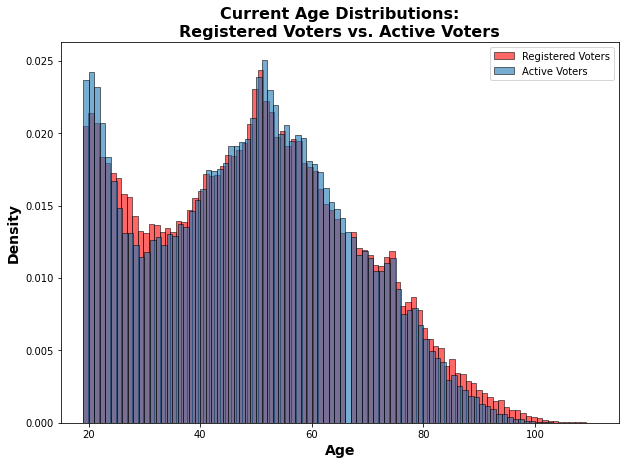

In [34]:
compare_age_distr(uc_vreg, 'Registered Voters', 
                  active_voters, 'Active Voters');

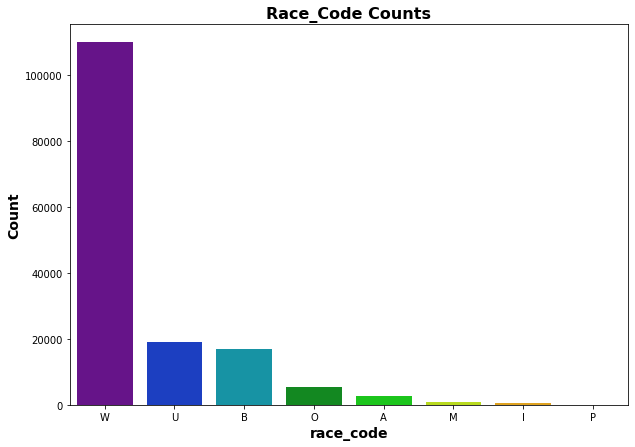

In [35]:
plot_count('race_code', active_voters);

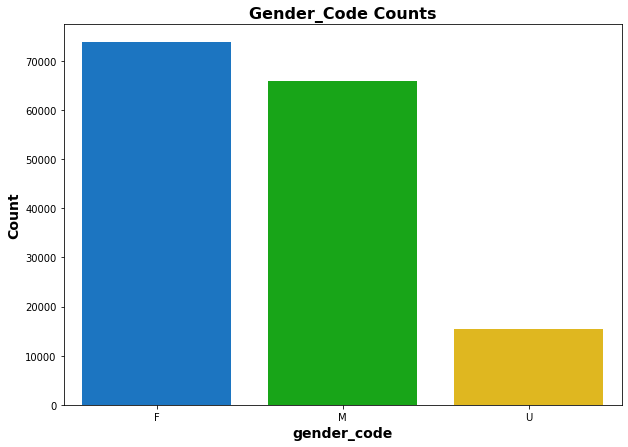

In [36]:
plot_count('gender_code', active_voters);

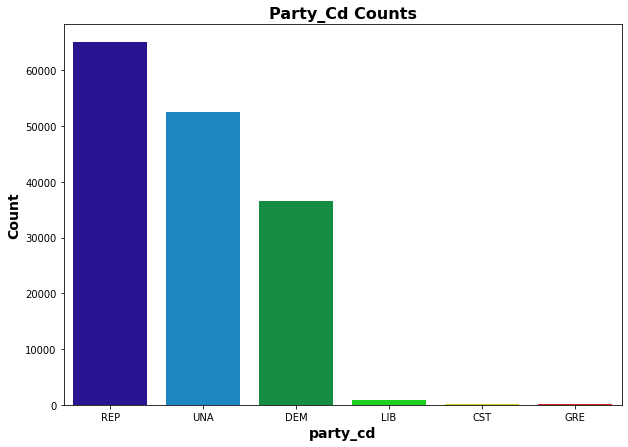

In [37]:
plot_count('party_cd', active_voters);

### Denied Voters

In [38]:
denied_voters = uc_vreg.groupby('voter_status_desc').get_group('DENIED')
print(len(denied_voters))
denied_voters.head()

1356


county_id county_desc  voter_reg_num status_cd voter_status_desc  \
124         90       UNION         265544         D            DENIED   
330         90       UNION         365813         D            DENIED   
529         90       UNION         241596         D            DENIED   
581         90       UNION         199199         D            DENIED   
596         90       UNION         318111         D            DENIED   

    reason_cd             voter_status_reason_desc absent_ind name_prefx_cd  \
124        DU  VERIFICATION RETURNED UNDELIVERABLE                            
330        DU  VERIFICATION RETURNED UNDELIVERABLE                            
529        DU  VERIFICATION RETURNED UNDELIVERABLE                            
581        DU  VERIFICATION RETURNED UNDELIVERABLE                            
596        DU  VERIFICATION RETURNED UNDELIVERABLE                            

       last_name first_name middle_name name_suffix_lbl  \
124  ABDELRAHMAN     SAMIRA        IMAD             NaN   
330      ABSHERE  CHRISTINE         MAE             NaN   
529        ADAMO     ANGELO         NaN             NaN   
581        ADAMS     CHERYL      YVONNE             NaN   
596        ADAMS    DANIELE   ELIZABETH             NaN   

           res_street_address res_city_desc state_cd  zip_code  \
124  1007  MILLS HARRIS RD       MARSHVILLE       NC   28103.0   
330  1516  MILLS HARRIS RD          WINGATE       NC   28174.0   
529      1003  SANDBOX CIR     INDIAN TRAIL       NC   28079.0   
581         4909 E HWY 74           WINGATE       NC   28174.0   
596   3300  BROOKSTONE TRL     INDIAN TRAIL       NC   28079.0   

               mail_addr1 mail_addr2 mail_addr3 mail_addr4     mail_city  \
124  1007 MILLS HARRIS RD        NaN        NaN        NaN    MARSHVILLE   
330  1516 MILLS HARRIS RD        NaN        NaN        NaN       WINGATE   
529      1003 SANDBOX CIR        NaN        NaN        NaN  INDIAN TRAIL   
581         4909 E HWY 74        NaN        NaN        NaN       WINGATE   
596   3300 BROOKSTONE TRL        NaN        NaN        NaN  INDIAN TRAIL   

    mail_state mail_zipcode  full_phone_number race_code ethnic_code party_cd  \
124         NC        28103                NaN         B          NL      UNA   
330         NC        28174                NaN         U          UN      REP   
529         NC        28079                NaN         W          NL      UNA   
581         NC        28174                NaN         W          NL      UNA   
596         NC        28079                NaN         W          NL      UNA   

    gender_code  birth_age birth_state drivers_lic  registr_dt precinct_abbrv  \
124           F         29          NC           Y  07/27/2012            NaN   
330           U         60         NaN           Y  08/06/2020            NaN   
529           M         77          OC           Y  05/01/2009            NaN   
581           F         50          TX           Y  08/03/2005            NaN   
596           F         32          OC           Y  10/29/2016            NaN   

    precinct_desc  municipality_abbrv municipality_desc  ward_abbrv  \
124           NaN                 NaN               NaN         NaN   
330           NaN                 NaN               NaN         NaN   
529           NaN                 NaN               NaN         NaN   
581           NaN                 NaN               NaN         NaN   
596           NaN                 NaN               NaN         NaN   

     ward_desc  cong_dist_abbrv super_court_abbrv judic_dist_abbrv  \
124        NaN              NaN               NaN              NaN   
330        NaN              NaN               NaN              NaN   
529        NaN              NaN               NaN              NaN   
581        NaN              NaN               NaN              NaN   
596        NaN              NaN               NaN              NaN   

     nc_senate_abbrv  nc_house_abbrv  county_commiss_abbrv  

In [39]:
denied_voters['voter_status_reason_desc'].value_counts()

VERIFICATION RETURNED UNDELIVERABLE    1356
Name: voter_status_reason_desc, dtype: int64

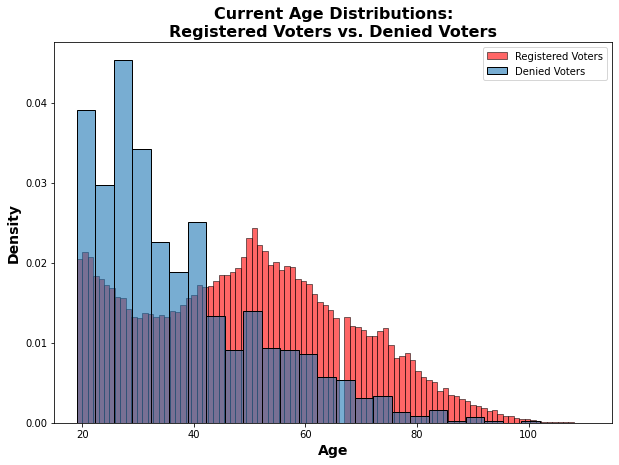

In [40]:
compare_age_distr(uc_vreg, 'Registered Voters', 
                  denied_voters, 'Denied Voters');

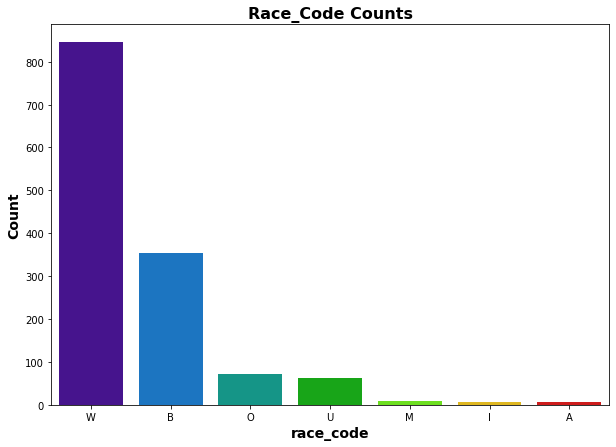

In [41]:
plot_count('race_code', denied_voters);

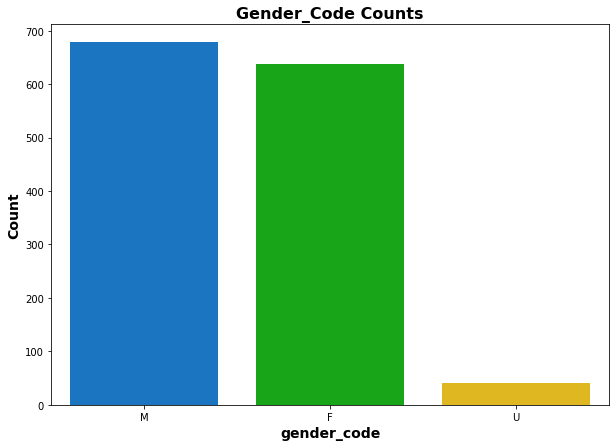

In [42]:
plot_count('gender_code', denied_voters);

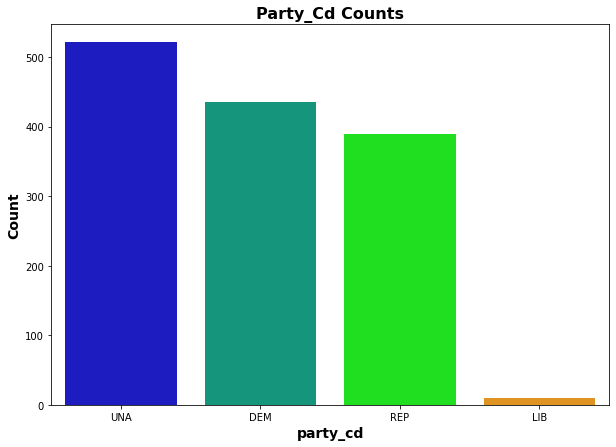

In [43]:
plot_count('party_cd', denied_voters);

### Inactive Voters

In [44]:
inactive_voters = uc_vreg.groupby('voter_status_desc').get_group('INACTIVE')
print(len(inactive_voters))
inactive_voters.head()

14748


county_id county_desc  voter_reg_num status_cd voter_status_desc  \
21         90       UNION         283607         I          INACTIVE   
35         90       UNION         304093         I          INACTIVE   
45         90       UNION         200444         I          INACTIVE   
87         90       UNION         240783         I          INACTIVE   
90         90       UNION         236007         I          INACTIVE   

   reason_cd   voter_status_reason_desc absent_ind name_prefx_cd  \
21        IN  CONFIRMATION NOT RETURNED                            
35        IN  CONFIRMATION NOT RETURNED                            
45        IN  CONFIRMATION NOT RETURNED                            
87        IN  CONFIRMATION NOT RETURNED                            
90        IN  CONFIRMATION NOT RETURNED                            

         last_name first_name middle_name name_suffix_lbl  \
21            ABAR    KRISTEN      ELAINE             NaN   
35  ABARCA-NICOLAS       JOSE     ALBERTO             NaN   
45           ABBAS       OMAR     MOHAMED             NaN   
87          ABBOTT       MARY         SUE             NaN   
90          ABBOTT       NEIL         NaN             NaN   

               res_street_address res_city_desc state_cd  zip_code  \
21             5523  CHERAW RD       MARSHVILLE       NC   28103.0   
35               616  JONES ST           MONROE       NC   28110.0   
45  2206  HONEYCUTT SIMPSON RD           MONROE       NC   28110.0   
87              4122  EUTAW DR           WAXHAW       NC   28173.0   
90           5127  CRUZ BAY DR           MONROE       NC   28110.0   

                   mail_addr1 mail_addr2 mail_addr3 mail_addr4   mail_city  \
21             5523 CHERAW RD        NaN        NaN        NaN  MARSHVILLE   
35               616 JONES ST        NaN        NaN        NaN      MONROE   
45  2206 HONEYCUTT SIMPSON RD        NaN        NaN        NaN      MONROE   
87              4122 EUTAW DR        NaN        NaN        NaN      WAXHAW   
90           5127 CRUZ BAY DR        NaN        NaN        NaN      MONROE   

   mail_state mail_zipcode  full_phone_number race_code ethnic_code party_cd  \
21         NC        28103                NaN         W          NL      DEM   
35         NC        28110                NaN         O          NL      UNA   
45         NC        28110                NaN         O          UN      UNA   
87         NC        28173                NaN         W          NL      UNA   
90         NC        28110                NaN         W          UN      UNA   

   gender_code  birth_age birth_state drivers_lic  registr_dt precinct_abbrv  \
21           F         25          NC           Y  02/17/2014            026   
35           M         23          NC           Y  04/26/2016            004   
45           M         34          NJ           Y  10/03/2005            013   
87           F         41          WV           Y  03/04/2009           020A   
90           U         42         NaN           Y  10/10/2008            031   

   precinct_desc  municipality_abbrv municipality_desc  ward_abbrv  ward_desc  \
21           026                 NaN               NaN         NaN        NaN   
35           004                 2.0            MONROE         NaN        NaN   
45           013                98.0        UNIONVILLE         NaN        NaN   
87          020A                 5.0            WAXHAW         NaN        NaN   
90           031                 NaN               NaN         NaN        NaN   

    cong_dist_abbrv super_court_abbrv judic_dist_abbrv  nc_senate_abbrv  \
21              9.0               20B              20C             35.0   
35              9.0               20B              20B             35.0   
45              9.0               20B              20B             35.0   
87              9.0               20B              20C             35.0   
90              9.0               20B              20C             35.0   

    n

In [45]:
inactive_voters['voter_status_reason_desc'].value_counts()

CONFIRMATION NOT RETURNED              9333
CONFIRMATION RETURNED UNDELIVERABLE    5414
ADMINISTRATIVE                            1
Name: voter_status_reason_desc, dtype: int64

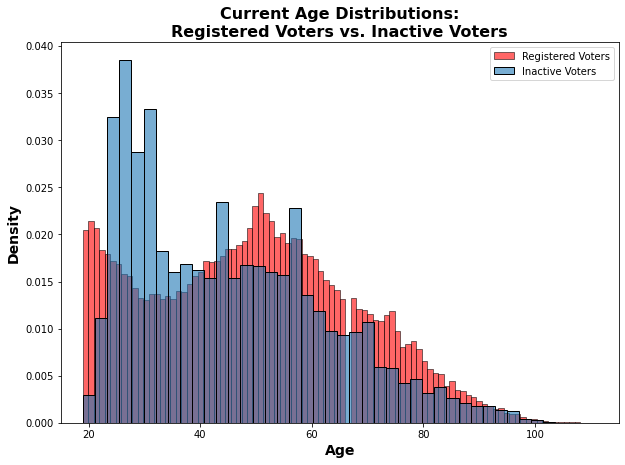

In [46]:
compare_age_distr(uc_vreg, 'Registered Voters', 
                  inactive_voters, 'Inactive Voters');

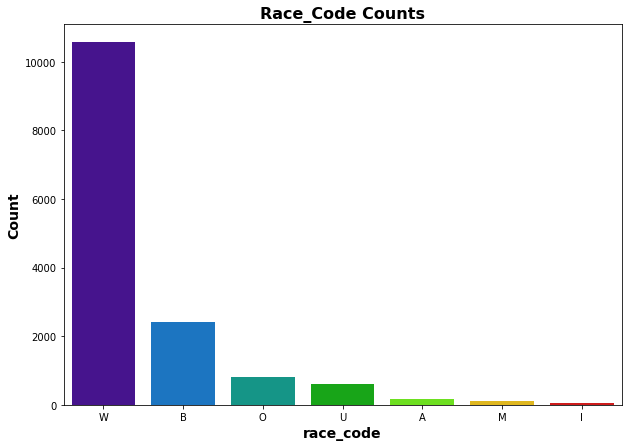

In [47]:
plot_count('race_code', inactive_voters);

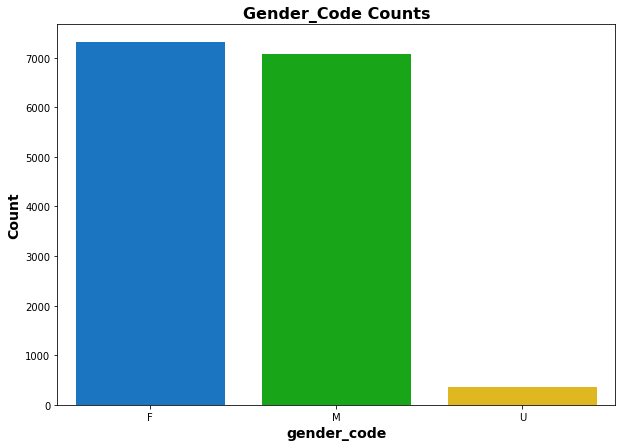

In [48]:
plot_count('gender_code', inactive_voters);

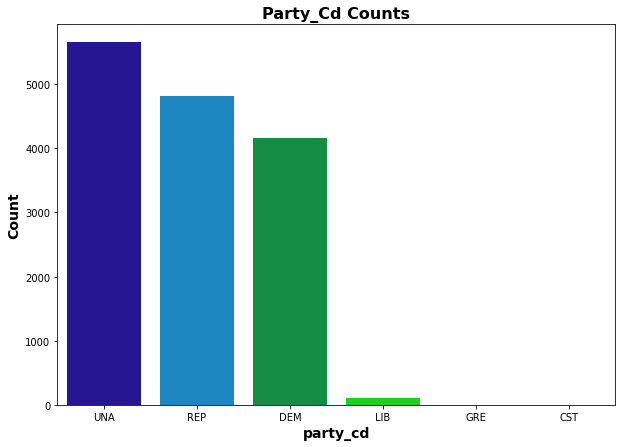

In [49]:
plot_count('party_cd', inactive_voters);

### Removed Voters

In [50]:
removed_voters = uc_vreg.groupby('voter_status_desc').get_group('REMOVED')
print(len(removed_voters))
removed_voters.head()

13554


county_id county_desc  voter_reg_num status_cd voter_status_desc  \
20         90       UNION         259695         R           REMOVED   
62         90       UNION         243470         R           REMOVED   
68         90       UNION         190348         R           REMOVED   
73         90       UNION         157042         R           REMOVED   
78         90       UNION         262940         R           REMOVED   

   reason_cd                           voter_status_reason_desc absent_ind  \
20        RM  REMOVED AFTER 2 FED GENERAL ELECTIONS IN INACT...              
62        RL                                  MOVED FROM COUNTY              
68        RS                                   MOVED FROM STATE              
73        RD                                           DECEASED              
78        RM  REMOVED AFTER 2 FED GENERAL ELECTIONS IN INACT...              

   name_prefx_cd last_name first_name middle_name name_suffix_lbl  \
20                    ABAR      JAMES   FREDERICK                   
62                   ABBEN     LAURIN     DOROTHY                   
68                  ABBOTT       ALAN      WALTER                   
73                  ABBOTT    CHARLES         NaN                   
78                  ABBOTT     HARLEY    CHEYENNE                   

   res_street_address res_city_desc state_cd  zip_code mail_addr1 mail_addr2  \
20            REMOVED           NaN      NaN       NaN                         
62            REMOVED           NaN      NaN       NaN                         
68            REMOVED           NaN      NaN       NaN                         
73            REMOVED           NaN      NaN       NaN                         
78            REMOVED           NaN      NaN       NaN                         

   mail_addr3 mail_addr4 mail_city mail_state mail_zipcode  full_phone_number  \
20                                                                        NaN   
62                                                                        NaN   
68                                                                        NaN   
73                                                                        NaN   
78                                                                        NaN   

   race_code ethnic_code party_cd gender_code  birth_age birth_state  \
20         W          NL      REP           M         50          MI   
62         W          NL      REP           F         30          FL   
68         W          NL      REP           M         53          NY   
73         B          NL      DEM           M         62         NaN   
78         W          NL      DEM           F         28          WV   

   drivers_lic  registr_dt precinct_abbrv precinct_desc  municipality_abbrv  \
20           Y  02/09/2012            NaN           NaN                 NaN   
62           N  09/01/2009            NaN           NaN                 NaN   
68           Y  09/15/2004            NaN           NaN                 NaN   
73           Y  06/12/2000            NaN           NaN                 NaN   
78           Y  07/10/2012            NaN           NaN                 NaN   

   municipality_desc  ward_abbrv  ward_desc  cong_dist_abbrv  \
20               NaN         NaN        NaN              NaN   
62               NaN         NaN        NaN              NaN   
68               NaN         NaN        NaN              NaN   
73               NaN         NaN        NaN              NaN   
78               NaN         NaN        NaN              NaN   

   super_court_abbrv judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  \
20               NaN              NaN              NaN             NaN   
62               NaN              NaN              NaN             NaN   
68               NaN              NaN              NaN             NaN   
73               NaN              NaN              NaN             NaN   
78               NaN              NaN              NaN  

In [51]:
removed_voters['voter_status_reason_desc'].value_counts()

DECEASED                                                    6179
MOVED FROM STATE                                            3720
REMOVED AFTER 2 FED GENERAL ELECTIONS IN INACTIVE STATUS    1569
MOVED FROM COUNTY                                           1418
MOVED WITHIN STATE                                           169
FELONY SENTENCE COMPLETED                                    158
REQUEST FROM VOTER                                           126
FELONY CONVICTION                                            110
TEMPORARY REGISTRANT                                          73
DUPLICATE                                                     27
ADMINISTRATIVE                                                 5
Name: voter_status_reason_desc, dtype: int64

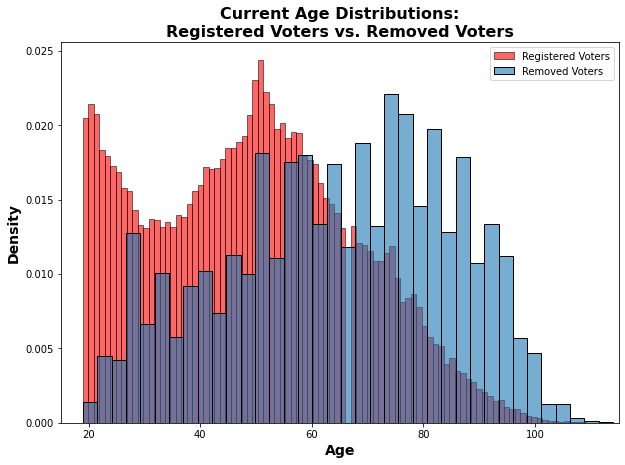

In [52]:
compare_age_distr(uc_vreg, 'Registered Voters', 
                  removed_voters, 'Removed Voters');

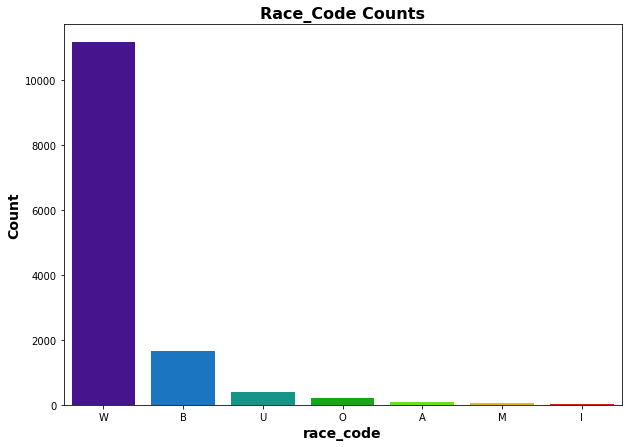

In [53]:
plot_count('race_code', removed_voters);

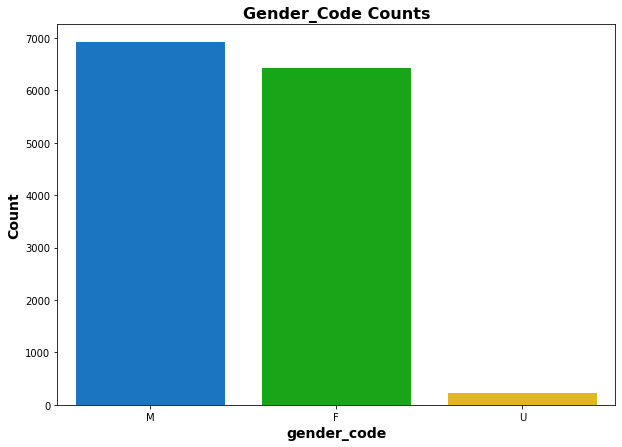

In [54]:
plot_count('gender_code', removed_voters);

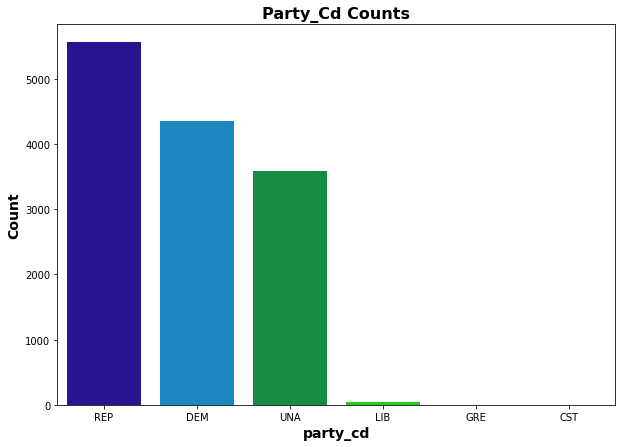

In [55]:
plot_count('party_cd', removed_voters);

## Merge Voter Registration Data with Voter History Data

In [56]:
## Merge voter registration information onto records of voter history based 
  ## on unique ncid
    
## Use right join so we're only including ncid's for which their is
  ## registration and demographic information, including for those 
    ## people who are registered, but have never voted
all_uc_voters = uc_vhis.merge(uc_vreg.drop(columns=['county_id', 'county_desc',
                                                'voter_reg_num'], axis=1),
                                       how='right', on='ncid')
# inspect new dataframe
display(all_uc_voters.head())
all_uc_voters.tail()

county_id county_desc  voter_reg_num election_lbl       election_desc  \
0       90.0       UNION       285297.0   11/08/2016  11/08/2016 GENERAL   
1       90.0       UNION       285297.0   09/10/2019  09/10/2019 GENERAL   
2       90.0       UNION       285297.0   03/03/2020  03/03/2020 PRIMARY   
3       90.0       UNION       285297.0   11/06/2018  11/06/2018 GENERAL   
4       90.0       UNION       285297.0   11/03/2020  11/03/2020 GENERAL   

      voting_method voted_party_cd voted_party_desc pct_label pct_description  \
0  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   
1  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   
2         IN-PERSON            REP       REPUBLICAN       016             016   
3  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   
4  ABSENTEE ONESTOP            REP       REPUBLICAN       016             016   

       ncid  voted_county_id voted_county_desc vtd_label vtd_description  \
0  AA100547             90.0             UNION       016             016   
1  AA100547             90.0             UNION       016             016   
2  AA100547             90.0             UNION       016             016   
3  AA100547             90.0             UNION       016             016   
4  AA100547             90.0             UNION       016             016   

  status_cd voter_status_desc reason_cd voter_status_reason_desc absent_ind  \
0         A            ACTIVE        AV                 VERIFIED              
1         A            ACTIVE        AV                 VERIFIED              
2         A            ACTIVE        AV                 VERIFIED              
3         A            ACTIVE        AV                 VERIFIED              
4         A            ACTIVE        AV                 VERIFIED              

  name_prefx_cd  last_name first_name middle_name name_suffix_lbl  \
0                FREDERICK     DONALD      EUGENE             NaN   
1                FREDERICK     DONALD      EUGENE             NaN   
2                FREDERICK     DONALD      EUGENE             NaN   
3                FREDERICK     DONALD      EUGENE             NaN   
4                FREDERICK     DONALD      EUGENE             NaN   

    res_street_address res_city_desc state_cd  zip_code       mail_addr1  \
0  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0  5514 BEVERLY DR   
1  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0  5514 BEVERLY DR   
2  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0  5514 BEVERLY DR   
3  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0  5514 BEVERLY DR   
4  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0  5514 BEVERLY DR   

  mail_addr2 mail_addr3 mail_addr4     mail_city mail_state mail_zipcode  \
0        NaN        NaN        NaN  INDIAN TRAIL         NC        28079   
1        NaN        NaN        NaN  INDIAN TRAIL         NC        28079   
2        NaN        NaN        NaN  INDIAN TRAIL         NC        28079   
3        NaN        NaN        NaN  INDIAN TRAIL         NC        28079   
4        NaN        NaN        NaN  INDIAN TRAIL         NC        28079   

   full_phone_number race_code ethnic_code party_cd gender_code  birth_age  \
0                NaN         W          UN      REP           M         66   
1                NaN         W          UN      REP           M         66   
2                NaN         W          UN      REP           M         66   
3                NaN         W          UN      REP           M         66   
4                NaN         W          UN      REP           M         66   

  birth_state drivers_lic  registr_dt precinct_abbrv precinct_desc  \
0          NC           Y  03/31/2014            016           016   
1          NC           Y  03/31/2014            016           016   
2          NC           Y  03/31/2014            016           016   
3          NC           Y  03/31/2014            

county_id county_desc  voter_reg_num election_lbl election_desc  \
827093        NaN         NaN            NaN          NaN           NaN   
827094        NaN         NaN            NaN          NaN           NaN   
827095        NaN         NaN            NaN          NaN           NaN   
827096        NaN         NaN            NaN          NaN           NaN   
827097        NaN         NaN            NaN          NaN           NaN   

       voting_method voted_party_cd voted_party_desc pct_label  \
827093           NaN            NaN              NaN       NaN   
827094           NaN            NaN              NaN       NaN   
827095           NaN            NaN              NaN       NaN   
827096           NaN            NaN              NaN       NaN   
827097           NaN            NaN              NaN       NaN   

       pct_description      ncid  voted_county_id voted_county_desc vtd_label  \
827093             NaN  EF237871              NaN               NaN       NaN   
827094             NaN   EM25093              NaN               NaN       NaN   
827095             NaN  EF181504              NaN               NaN       NaN   
827096             NaN  EF250083              NaN               NaN       NaN   
827097             NaN  EF219265              NaN               NaN       NaN   

       vtd_description status_cd voter_status_desc reason_cd  \
827093             NaN         A            ACTIVE        AV   
827094             NaN         A            ACTIVE        AV   
827095             NaN         I          INACTIVE        IN   
827096             NaN         A            ACTIVE        AN   
827097             NaN         I          INACTIVE        IU   

                   voter_status_reason_desc absent_ind name_prefx_cd  \
827093                             VERIFIED                            
827094                             VERIFIED                            
827095            CONFIRMATION NOT RETURNED                            
827096                       UNVERIFIED NEW                            
827097  CONFIRMATION RETURNED UNDELIVERABLE                            

       last_name first_name  middle_name name_suffix_lbl  \
827093   ZULUETA      ETHAN    FRANCISCO             NaN   
827094    ZUNKER      JASON       ARTHUR             NaN   
827095   ZURALES       MARK  CHRISTOPHER             NaN   
827096  ZWIEBACK   ADRIENNE        RENEE             NaN   
827097   ZYWICKI   JENNIFER          ANN             NaN   

                res_street_address res_city_desc state_cd  zip_code  \
827093        3009  SHALFORD LN         MATTHEWS       NC   28104.0   
827094  2512  LOGAN CAROLINE LN           MONROE       NC   28110.0   
827095   9207  RUSTIC CREEK TRL           WAXHAW       NC   28173.0   
827096       5601  BALLENGER CT           WAXHAW       NC   28173.0   
827097       5719  PARKSTONE DR         MATTHEWS       NC   28104.0   

                    mail_addr1 mail_addr2 mail_addr3 mail_addr4 mail_city  \
827093        3009 SHALFORD LN        NaN        NaN        NaN  MATTHEWS   
827094  2512 LOGAN CAROLINE LN        NaN        NaN        NaN    MONROE   
827095   9207 RUSTIC CREEK TRL        NaN        NaN        NaN    WAXHAW   
827096       5601 BALLENGER CT        NaN        NaN        NaN    WAXHAW   
827097       5719 PARKSTONE DR        NaN        NaN        NaN  MATTHEWS   

       mail_state mail_zipcode  full_phone_number race_code ethnic_code  \
827093         NC        28104                NaN         A          NL   
827094         NC        28110                NaN         W          NL   
827095         NC        28173                NaN         W          NL   
827096         NC        28173                NaN         W          NL   
827097         NC        28104                NaN         W          NL   

       party_cd gender_code  birth_age birth_state drivers_lic  registr_dt  \
827093      REP           M         19          NC           Y  01/03/2020 

## Drop 'Removed' and 'Denied' Voters - Further Exploration

In [57]:
## Drop voters who have been removed or had their registration denied
uc_voters = all_uc_voters.loc[all_uc_voters['voter_status_desc'] != 'REMOVED']
uc_voters = uc_voters.loc[uc_voters['voter_status_desc'] != 'DENIED']
# uc_voters.info()

In [58]:
## Check remaining number of unique individuals represented in the data
uc_voters['ncid'].nunique()

170098

## Engineer Features for Grouping/ Database Manipulation

In [59]:
## Create a new column specifying the election category based on the
  ## election description col
uc_voters.insert(loc=5, column='election_cat', 
                 value=uc_voters['election_desc'].str.split(n=1,
                                                            expand=True)[1])
# If the category was general or primary, leave as is, otherwise 'other'
uc_voters['election_cat'] = np.where(uc_voters['election_cat'].isin(
                                                    ['GENERAL', 'PRIMARY']),
                                     uc_voters['election_cat'], 'other')

In [60]:
## Recast election_lbl as datetime and create a new col for just the year
uc_voters['election_lbl'] = pd.to_datetime(uc_voters['election_lbl'])
uc_voters.insert(loc=5, column='election_yr',
                 value=uc_voters['election_lbl'].dt.year)

In [61]:
## Create a new binary variable indicating if it was a major election
uc_voters.insert(loc=7, column='major_elec',
                 value=np.where(((uc_voters['election_yr']%2 == 0) & 
                                 (uc_voters['election_cat'].isin(
                                     ['GENERAL', 'PRIMARY']))),
                                1,0))

In [62]:
## Null values in the election_desc col indicate individuals that are 
  ## registered to vote, but have not voted in a recent major election.
    ## Thus, election_cat, major_elec, and presid_elec 
    ## are irrelevant for these records
# Fill irrelevant fields with null values
uc_voters.loc[uc_voters['election_desc'].isna(),
              ['election_cat', 'major_elec']] = np.nan

# Fill with NaN with 'None' in election_desc col to preserve info for
  # registered voters without a voting history when merging df's based on 
    # ncid and election_desc below
uc_voters['election_desc'].fillna('None', inplace=True)

# Inspect updated dataframe
uc_voters.head()

county_id county_desc  voter_reg_num election_lbl       election_desc  \
0       90.0       UNION       285297.0   2016-11-08  11/08/2016 GENERAL   
1       90.0       UNION       285297.0   2019-09-10  09/10/2019 GENERAL   
2       90.0       UNION       285297.0   2020-03-03  03/03/2020 PRIMARY   
3       90.0       UNION       285297.0   2018-11-06  11/06/2018 GENERAL   
4       90.0       UNION       285297.0   2020-11-03  11/03/2020 GENERAL   

   election_yr election_cat  major_elec     voting_method voted_party_cd  \
0       2016.0      GENERAL         1.0  ABSENTEE ONESTOP            REP   
1       2019.0      GENERAL         0.0  ABSENTEE ONESTOP            REP   
2       2020.0      PRIMARY         1.0         IN-PERSON            REP   
3       2018.0      GENERAL         1.0  ABSENTEE ONESTOP            REP   
4       2020.0      GENERAL         1.0  ABSENTEE ONESTOP            REP   

  voted_party_desc pct_label pct_description      ncid  voted_county_id  \
0       REPUBLICAN       016             016  AA100547             90.0   
1       REPUBLICAN       016             016  AA100547             90.0   
2       REPUBLICAN       016             016  AA100547             90.0   
3       REPUBLICAN       016             016  AA100547             90.0   
4       REPUBLICAN       016             016  AA100547             90.0   

  voted_county_desc vtd_label vtd_description status_cd voter_status_desc  \
0             UNION       016             016         A            ACTIVE   
1             UNION       016             016         A            ACTIVE   
2             UNION       016             016         A            ACTIVE   
3             UNION       016             016         A            ACTIVE   
4             UNION       016             016         A            ACTIVE   

  reason_cd voter_status_reason_desc absent_ind name_prefx_cd  last_name  \
0        AV                 VERIFIED                           FREDERICK   
1        AV                 VERIFIED                           FREDERICK   
2        AV                 VERIFIED                           FREDERICK   
3        AV                 VERIFIED                           FREDERICK   
4        AV                 VERIFIED                           FREDERICK   

  first_name middle_name name_suffix_lbl   res_street_address res_city_desc  \
0     DONALD      EUGENE             NaN  5514  BEVERLY DR     INDIAN TRAIL   
1     DONALD      EUGENE             NaN  5514  BEVERLY DR     INDIAN TRAIL   
2     DONALD      EUGENE             NaN  5514  BEVERLY DR     INDIAN TRAIL   
3     DONALD      EUGENE             NaN  5514  BEVERLY DR     INDIAN TRAIL   
4     DONALD      EUGENE             NaN  5514  BEVERLY DR     INDIAN TRAIL   

  state_cd  zip_code       mail_addr1 mail_addr2 mail_addr3 mail_addr4  \
0       NC   28079.0  5514 BEVERLY DR        NaN        NaN        NaN   
1       NC   28079.0  5514 BEVERLY DR        NaN        NaN        NaN   
2       NC   28079.0  5514 BEVERLY DR        NaN        NaN        NaN   
3       NC   28079.0  5514 BEVERLY DR        NaN        NaN        NaN   
4       NC   28079.0  5514 BEVERLY DR        NaN        NaN        NaN   

      mail_city mail_state mail_zipcode  full_phone_number race_code  \
0  INDIAN TRAIL         NC        28079                NaN         W   
1  INDIAN TRAIL         NC        28079                NaN         W   
2  INDIAN TRAIL         NC        28079                NaN         W   
3  INDIAN TRAIL         NC        28079                NaN         W   
4  INDIAN TRAIL         NC        28079                NaN         W   

  ethnic_code party_cd gender_code  birth_age birth_state drivers_lic  \
0          UN      REP           M         66          NC           Y   
1          UN      REP           M         66          NC           Y   
2          UN      REP           M         66          NC           Y   
3          UN      REP           M         66          NC           Y   


In [63]:
## Check number of unique individuals represented by the data
uc_voters['ncid'].nunique()

170098

In [64]:
## Store index of non-major and non-null election types
other_elec_idx = uc_voters.loc[uc_voters['election_cat']=='other'].index

## Create a df containing only major and null elections
major_elec_df = uc_voters.drop(index=other_elec_idx)

# Check number of unique individuals that voted in a recent major election, 
  # plus those with no voting history
print(major_elec_df['ncid'].nunique())

# 131 registered voters voted in a non-major election, but no major elections
uc_voters['ncid'].nunique() - major_elec_df['ncid'].nunique()

169967


131

## Merge DataFrames - Focus on Recent Major Elections

In [65]:
## Get list of unique ncids
uc_ncid_list = list(uc_voters['ncid'].unique())

## Get list of unique election descriptions
major_elections = list(uc_voters.groupby('major_elec').get_group(1)['election_desc'].unique())

## Add 'None' to the list to capture individuals that have not voted in any 
  ## recent major election when merging dataframes on ncid and election_desc
elec_desc_list = major_elections + ['None']
elec_desc_list

['11/08/2016 GENERAL',
 '03/03/2020 PRIMARY',
 '11/06/2018 GENERAL',
 '11/03/2020 GENERAL',
 '05/08/2012 PRIMARY',
 '11/06/2012 GENERAL',
 '11/04/2014 GENERAL',
 '05/06/2014 PRIMARY',
 '03/15/2016 PRIMARY',
 '05/08/2018 PRIMARY',
 'None']

In [66]:
## Create multiindex that lists every election for every registered voter
mltidx = pd.MultiIndex.from_tuples(
    [(ncid, elec) for ncid in uc_ncid_list for elec in elec_desc_list],
    names=['ncid', 'election_desc'])

## Use multiindex to create new dataframe
elecs_by_voter = pd.DataFrame(index=mltidx)

In [67]:
## Check length and inspect structure of new dataframe
print(len(elecs_by_voter))
elecs_by_voter.head(15)

1871078


Empty DataFrame
Columns: []
Index: [(AA100547, 11/08/2016 GENERAL), (AA100547, 03/03/2020 PRIMARY), (AA100547, 11/06/2018 GENERAL), (AA100547, 11/03/2020 GENERAL), (AA100547, 05/08/2012 PRIMARY), (AA100547, 11/06/2012 GENERAL), (AA100547, 11/04/2014 GENERAL), (AA100547, 05/06/2014 PRIMARY), (AA100547, 03/15/2016 PRIMARY), (AA100547, 05/08/2018 PRIMARY), (AA100547, None), (AA108801, 11/08/2016 GENERAL), (AA108801, 03/03/2020 PRIMARY), (AA108801, 11/06/2018 GENERAL), (AA108801, 11/03/2020 GENERAL)]

In [68]:
elecs_by_voter.reset_index(inplace=True)
elecs_by_voter.head(15)

ncid       election_desc
0   AA100547  11/08/2016 GENERAL
1   AA100547  03/03/2020 PRIMARY
2   AA100547  11/06/2018 GENERAL
3   AA100547  11/03/2020 GENERAL
4   AA100547  05/08/2012 PRIMARY
5   AA100547  11/06/2012 GENERAL
6   AA100547  11/04/2014 GENERAL
7   AA100547  05/06/2014 PRIMARY
8   AA100547  03/15/2016 PRIMARY
9   AA100547  05/08/2018 PRIMARY
10  AA100547                None
11  AA108801  11/08/2016 GENERAL
12  AA108801  03/03/2020 PRIMARY
13  AA108801  11/06/2018 GENERAL
14  AA108801  11/03/2020 GENERAL

In [69]:
## Merge voter histories using the created multiindex as the keys to join
  ## each ncid onto every election and 'None'
voter_elecs = elecs_by_voter.merge(uc_vhis, how='left',
                                   on=['ncid', 'election_desc'])
# Inspect new df
print(len(voter_elecs))
display(voter_elecs.head())
voter_elecs.tail()

1871087


ncid       election_desc  county_id county_desc  voter_reg_num  \
0  AA100547  11/08/2016 GENERAL       90.0       UNION       285297.0   
1  AA100547  03/03/2020 PRIMARY       90.0       UNION       285297.0   
2  AA100547  11/06/2018 GENERAL       90.0       UNION       285297.0   
3  AA100547  11/03/2020 GENERAL       90.0       UNION       285297.0   
4  AA100547  05/08/2012 PRIMARY       90.0       UNION       285297.0   

  election_lbl     voting_method voted_party_cd voted_party_desc pct_label  \
0   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN       016   
1   03/03/2020         IN-PERSON            REP       REPUBLICAN       016   
2   11/06/2018  ABSENTEE ONESTOP            REP       REPUBLICAN       016   
3   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN       016   
4   05/08/2012         IN-PERSON            REP       REPUBLICAN       G07   

  pct_description  voted_county_id voted_county_desc vtd_label vtd_description  
0             016             90.0             UNION       016             016  
1             016             90.0             UNION       016             016  
2             016             90.0             UNION       016             016  
3             016             90.0             UNION       016             016  
4             G07             41.0          GUILFORD       G07             G07

ncid       election_desc  county_id county_desc  voter_reg_num  \
1871082  EF219265  11/04/2014 GENERAL        NaN         NaN            NaN   
1871083  EF219265  05/06/2014 PRIMARY        NaN         NaN            NaN   
1871084  EF219265  03/15/2016 PRIMARY        NaN         NaN            NaN   
1871085  EF219265  05/08/2018 PRIMARY        NaN         NaN            NaN   
1871086  EF219265                None        NaN         NaN            NaN   

        election_lbl voting_method voted_party_cd voted_party_desc pct_label  \
1871082          NaN           NaN            NaN              NaN       NaN   
1871083          NaN           NaN            NaN              NaN       NaN   
1871084          NaN           NaN            NaN              NaN       NaN   
1871085          NaN           NaN            NaN              NaN       NaN   
1871086          NaN           NaN            NaN              NaN       NaN   

        pct_description  voted_county_id voted_county_desc vtd_label  \
1871082             NaN              NaN               NaN       NaN   
1871083             NaN              NaN               NaN       NaN   
1871084             NaN              NaN               NaN       NaN   
1871085             NaN              NaN               NaN       NaN   
1871086             NaN              NaN               NaN       NaN   

        vtd_description  
1871082             NaN  
1871083             NaN  
1871084             NaN  
1871085             NaN  
1871086             NaN

In [70]:
## Check for duplicate rows
voter_elecs.duplicated().sum()

0

In [71]:
## Create a list of columns to drop when performing next merge to limit size
  ## of new dataframe
# List of columns that were mostly null for original merged df
mostly_null_cols = [col for col in all_uc_voters.columns if all_uc_voters[col].isna().mean() >= 0.9]

# List of columns that are filled with empty white space
empty_cols = [col for col in all_uc_voters.columns if all_uc_voters[col].unique()[0] == ' ']

# List of municipality and mailing address info columns 
  # (not very useful, a lot of NaN)
munic_cols = [col for col in all_uc_voters.columns if col.startswith('munic')]
mail_cols = [col for col in all_uc_voters.columns if col.startswith('mail')]

# Combine all lists into one list of columns to drop
cols_to_drop = mostly_null_cols + empty_cols + munic_cols + mail_cols

In [72]:
## Merge voter registration information onto the new df based on ncid
voter_elecs = voter_elecs.merge(uc_vreg.drop(columns=cols_to_drop+['county_id',
                                                      'county_desc',
                                                      'voter_reg_num'],
                                             axis=1),
                                how='left', on='ncid')
# Inspect resulting df
voter_elecs.head()

ncid       election_desc  county_id county_desc  voter_reg_num  \
0  AA100547  11/08/2016 GENERAL       90.0       UNION       285297.0   
1  AA100547  03/03/2020 PRIMARY       90.0       UNION       285297.0   
2  AA100547  11/06/2018 GENERAL       90.0       UNION       285297.0   
3  AA100547  11/03/2020 GENERAL       90.0       UNION       285297.0   
4  AA100547  05/08/2012 PRIMARY       90.0       UNION       285297.0   

  election_lbl     voting_method voted_party_cd voted_party_desc pct_label  \
0   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN       016   
1   03/03/2020         IN-PERSON            REP       REPUBLICAN       016   
2   11/06/2018  ABSENTEE ONESTOP            REP       REPUBLICAN       016   
3   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN       016   
4   05/08/2012         IN-PERSON            REP       REPUBLICAN       G07   

  pct_description  voted_county_id voted_county_desc vtd_label  \
0             016             90.0             UNION       016   
1             016             90.0             UNION       016   
2             016             90.0             UNION       016   
3             016             90.0             UNION       016   
4             G07             41.0          GUILFORD       G07   

  vtd_description status_cd voter_status_desc reason_cd  \
0             016         A            ACTIVE        AV   
1             016         A            ACTIVE        AV   
2             016         A            ACTIVE        AV   
3             016         A            ACTIVE        AV   
4             G07         A            ACTIVE        AV   

  voter_status_reason_desc  last_name first_name middle_name  \
0                 VERIFIED  FREDERICK     DONALD      EUGENE   
1                 VERIFIED  FREDERICK     DONALD      EUGENE   
2                 VERIFIED  FREDERICK     DONALD      EUGENE   
3                 VERIFIED  FREDERICK     DONALD      EUGENE   
4                 VERIFIED  FREDERICK     DONALD      EUGENE   

    res_street_address res_city_desc state_cd  zip_code race_code ethnic_code  \
0  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
1  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
2  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
3  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
4  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   

  party_cd gender_code  birth_age birth_state drivers_lic  registr_dt  \
0      REP           M         66          NC           Y  03/31/2014   
1      REP           M         66          NC           Y  03/31/2014   
2      REP           M         66          NC           Y  03/31/2014   
3      REP           M         66          NC           Y  03/31/2014   
4      REP           M         66          NC           Y  03/31/2014   

  precinct_abbrv precinct_desc  cong_dist_abbrv super_court_abbrv  \
0            016           016              9.0               20B   
1            016           016              9.0               20B   
2            016           016              9.0               20B   
3            016           016              9.0               20B   
4            016           016              9.0               20B   

  judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  \
0              20C             35.0            69.0                4.0   
1              20C             35.0            69.0                4.0   
2              20C             35.0            69.0                4.0   
3              20C             35.0            69.0                4.0   
4              20C             35.0            69.0                4.0   

  school_dist_desc  dist_1_abbrv         dist_1_desc confidential_ind  \
0        SCHOOL #4          30.0  30TH PROSECUTORIAL                N   
1        SCHOOL #4          30

<a id='maj_elec'></a>
## Major Elections

<a id='drop_dup'></a>
### Drop Duplicate Records

In [73]:
## Check for duplicate identical rows
voter_elecs.duplicated().sum()

0

In [74]:
## Check length of new df
len(voter_elecs)

1871087

In [75]:
## Check the intended length of the new df if every unique ncid
  ## appears only once for each election description
voter_elecs['ncid'].nunique() * voter_elecs['election_desc'].nunique()

1871078

In [76]:
## There are 9 instances where an ncid shows up as casting a vote
  ## more than once in the same election
voter_elecs.duplicated(subset=['ncid', 'election_desc']).sum()

9

In [77]:
## A total of 6 individuals show up twice for a single election
  ## One individual shows up twice in 3 separate elections
dup_ncid_elecs = voter_elecs.loc[voter_elecs.duplicated(subset=['ncid', 'election_desc'], keep=False)]
dup_ncid_elecs

ncid       election_desc  county_id county_desc  voter_reg_num  \
66893    CW1012090  11/06/2018 GENERAL       90.0       UNION       338735.0   
66894    CW1012090  11/06/2018 GENERAL       90.0       UNION       338735.0   
299663    DB153036  11/08/2016 GENERAL       90.0       UNION       364740.0   
299664    DB153036  11/08/2016 GENERAL       90.0       UNION       364740.0   
299669    DB153036  11/06/2012 GENERAL       90.0       UNION       364740.0   
299670    DB153036  11/06/2012 GENERAL       90.0       UNION       364740.0   
299673    DB153036  03/15/2016 PRIMARY       90.0       UNION       364740.0   
299674    DB153036  03/15/2016 PRIMARY       90.0       UNION       364740.0   
677802    EF164225  11/08/2016 GENERAL       90.0       UNION       252400.0   
677803    EF164225  11/08/2016 GENERAL       90.0       UNION       252400.0   
817629    EF186914  11/06/2012 GENERAL       90.0       UNION       307237.0   
817630    EF186914  11/06/2012 GENERAL       90.0       UNION       307237.0   
1500037    EF69085  11/06/2012 GENERAL       90.0       UNION       144979.0   
1500038    EF69085  11/06/2012 GENERAL       90.0       UNION       144979.0   
1542108    EF78820  11/08/2016 GENERAL       90.0       UNION       341724.0   
1542109    EF78820  11/08/2016 GENERAL       90.0       UNION       341724.0   
1613845    EF93894  11/06/2012 GENERAL       90.0       UNION       272193.0   
1613846    EF93894  11/06/2012 GENERAL       90.0       UNION       272193.0   

        election_lbl     voting_method voted_party_cd voted_party_desc  \
66893     11/06/2018       PROVISIONAL            REP       REPUBLICAN   
66894     11/06/2018         IN-PERSON            REP       REPUBLICAN   
299663    11/08/2016  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
299664    11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
299669    11/06/2012  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
299670    11/06/2012  ABSENTEE ONESTOP            REP       REPUBLICAN   
299673    03/15/2016  ABSENTEE ONESTOP            DEM       DEMOCRATIC   
299674    03/15/2016         IN-PERSON            REP       REPUBLICAN   
677802    11/08/2016         IN-PERSON            DEM       DEMOCRATIC   
677803    11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
817629    11/06/2012         IN-PERSON            REP       REPUBLICAN   
817630    11/06/2012  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
1500037   11/06/2012         IN-PERSON            REP       REPUBLICAN   
1500038   11/06/2012         IN-PERSON            REP       REPUBLICAN   
1542108   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
1542109   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
1613845   11/06/2012         IN-PERSON            DEM       DEMOCRATIC   
1613846   11/06/2012  ABSENTEE ONESTOP            DEM       DEMOCRATIC   

        pct_label pct_description  voted_county_id voted_county_desc  \
66893        020B            020B             90.0             UNION   
66894         058         PCT 058             60.0       MECKLENBURG   
299663        W16             W16             65.0       NEW HANOVER   
299664       0070           SALEM             12.0             BURKE   
299669        W25             W25             65.0       NEW HANOVER   
299670       0070           SALEM             12.0             BURKE   
299673        W16             W16             65.0       NEW HANOVER   
299674       0070           SALEM             12.0             BURKE   
677802       028D            028D             90.0             UNION   
677803        022         PCT 022             60.0       MECKLENBURG   
817629       038A            038A             90.0             UNION   
817630        CUL       CULLOWHEE             50.0           JACKSON   
1500037       039             039             90.0             UNION   
1500038       039             039             90.0             UNION   
154210

In [78]:
## Examine the complete recent voting history of the 7 ncid's that show up 
  ## twice for a single election to investigate how the records differ
    ## and determine which record(s) to drop
for ncid in dup_ncid_elecs['ncid'].unique():
    display(voter_elecs.loc[voter_elecs['ncid']==ncid])

ncid       election_desc  county_id county_desc  voter_reg_num  \
66891  CW1012090  11/08/2016 GENERAL       90.0       UNION       338735.0   
66892  CW1012090  03/03/2020 PRIMARY       90.0       UNION       338735.0   
66893  CW1012090  11/06/2018 GENERAL       90.0       UNION       338735.0   
66894  CW1012090  11/06/2018 GENERAL       90.0       UNION       338735.0   
66895  CW1012090  11/03/2020 GENERAL       90.0       UNION       338735.0   
66896  CW1012090  05/08/2012 PRIMARY        NaN         NaN            NaN   
66897  CW1012090  11/06/2012 GENERAL        NaN         NaN            NaN   
66898  CW1012090  11/04/2014 GENERAL       90.0       UNION       338735.0   
66899  CW1012090  05/06/2014 PRIMARY        NaN         NaN            NaN   
66900  CW1012090  03/15/2016 PRIMARY        NaN         NaN            NaN   
66901  CW1012090  05/08/2018 PRIMARY        NaN         NaN            NaN   
66902  CW1012090                None        NaN         NaN            NaN   

      election_lbl     voting_method voted_party_cd voted_party_desc  \
66891   11/08/2016         IN-PERSON            REP       REPUBLICAN   
66892   03/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
66893   11/06/2018       PROVISIONAL            REP       REPUBLICAN   
66894   11/06/2018         IN-PERSON            REP       REPUBLICAN   
66895   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
66896          NaN               NaN            NaN              NaN   
66897          NaN               NaN            NaN              NaN   
66898   11/04/2014         IN-PERSON            REP       REPUBLICAN   
66899          NaN               NaN            NaN              NaN   
66900          NaN               NaN            NaN              NaN   
66901          NaN               NaN            NaN              NaN   
66902          NaN               NaN            NaN              NaN   

      pct_label pct_description  voted_county_id voted_county_desc vtd_label  \
66891       058         PCT 058             60.0       MECKLENBURG       058   
66892      020B            020B             90.0             UNION      020B   
66893      020B            020B             90.0             UNION      020B   
66894       058         PCT 058             60.0       MECKLENBURG       058   
66895      020B            020B             90.0             UNION      020B   
66896       NaN             NaN              NaN               NaN       NaN   
66897       NaN             NaN              NaN               NaN       NaN   
66898       148         PCT 148             60.0       MECKLENBURG       148   
66899       NaN             NaN              NaN               NaN       NaN   
66900       NaN             NaN              NaN               NaN       NaN   
66901       NaN             NaN              NaN               NaN       NaN   
66902       NaN             NaN              NaN               NaN       NaN   

      vtd_description status_cd voter_status_desc reason_cd  \
66891             058         A            ACTIVE        AV   
66892            020B         A            ACTIVE        AV   
66893            020B         A            ACTIVE        AV   
66894             058         A            ACTIVE        AV   
66895            020B         A            ACTIVE        AV   
66896             NaN         A            ACTIVE        AV   
66897             NaN         A            ACTIVE        AV   
66898             148         A            ACTIVE        AV   
66899             NaN         A            ACTIVE        AV   
66900             NaN         A            ACTIVE        AV   
66901             NaN         A            ACTIVE        AV   
66902             NaN         A            ACTIVE        AV   

      voter_status_reason_desc last_name first_name middle_name  \
66891                 VERIFIED     RACER      JESSE      THOMAS   
66892                 VERIFIED     RACER      JESSE      THOMAS  

ncid       election_desc  county_id county_desc  voter_reg_num  \
299663  DB153036  11/08/2016 GENERAL       90.0       UNION       364740.0   
299664  DB153036  11/08/2016 GENERAL       90.0       UNION       364740.0   
299665  DB153036  03/03/2020 PRIMARY        NaN         NaN            NaN   
299666  DB153036  11/06/2018 GENERAL       90.0       UNION       364740.0   
299667  DB153036  11/03/2020 GENERAL       90.0       UNION       364740.0   
299668  DB153036  05/08/2012 PRIMARY       90.0       UNION       364740.0   
299669  DB153036  11/06/2012 GENERAL       90.0       UNION       364740.0   
299670  DB153036  11/06/2012 GENERAL       90.0       UNION       364740.0   
299671  DB153036  11/04/2014 GENERAL       90.0       UNION       364740.0   
299672  DB153036  05/06/2014 PRIMARY        NaN         NaN            NaN   
299673  DB153036  03/15/2016 PRIMARY       90.0       UNION       364740.0   
299674  DB153036  03/15/2016 PRIMARY       90.0       UNION       364740.0   
299675  DB153036  05/08/2018 PRIMARY        NaN         NaN            NaN   
299676  DB153036                None        NaN         NaN            NaN   

       election_lbl     voting_method voted_party_cd voted_party_desc  \
299663   11/08/2016  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
299664   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
299665          NaN               NaN            NaN              NaN   
299666   11/06/2018         IN-PERSON            UNA     UNAFFILIATED   
299667   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
299668   05/08/2012         IN-PERSON            DEM       DEMOCRATIC   
299669   11/06/2012  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
299670   11/06/2012  ABSENTEE ONESTOP            REP       REPUBLICAN   
299671   11/04/2014  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
299672          NaN               NaN            NaN              NaN   
299673   03/15/2016  ABSENTEE ONESTOP            DEM       DEMOCRATIC   
299674   03/15/2016         IN-PERSON            REP       REPUBLICAN   
299675          NaN               NaN            NaN              NaN   
299676          NaN               NaN            NaN              NaN   

       pct_label pct_description  voted_county_id voted_county_desc vtd_label  \
299663       W16             W16             65.0       NEW HANOVER       W16   
299664      0070           SALEM             12.0             BURKE      0070   
299665       NaN             NaN              NaN               NaN       NaN   
299666      CF02            CF02             65.0       NEW HANOVER      CF02   
299667      020A            020A             90.0             UNION      020A   
299668       W25             W25             65.0       NEW HANOVER       W25   
299669       W25             W25             65.0       NEW HANOVER       W25   
299670      0070           SALEM             12.0             BURKE      0070   
299671       W16             W16             65.0       NEW HANOVER       W16   
299672       NaN             NaN              NaN               NaN       NaN   
299673       W16             W16             65.0       NEW HANOVER       W16   
299674      0070           SALEM             12.0             BURKE      0070   
299675       NaN             NaN              NaN               NaN       NaN   
299676       NaN             NaN              NaN               NaN       NaN   

       vtd_description status_cd voter_status_desc reason_cd  \
299663             W16         A            ACTIVE        AV   
299664            0070         A            ACTIVE        AV   
299665             NaN         A            ACTIVE        AV   
299666            CF02         A            ACTIVE        AV   
299667            020A         A            ACTIVE        AV   
299668             W25         A            ACTIVE        AV   
299669             W25         A            ACTIVE        AV   
299670           

ncid       election_desc  county_id county_desc  voter_reg_num  \
677802  EF164225  11/08/2016 GENERAL       90.0       UNION       252400.0   
677803  EF164225  11/08/2016 GENERAL       90.0       UNION       252400.0   
677804  EF164225  03/03/2020 PRIMARY       90.0       UNION       252400.0   
677805  EF164225  11/06/2018 GENERAL       90.0       UNION       252400.0   
677806  EF164225  11/03/2020 GENERAL       90.0       UNION       252400.0   
677807  EF164225  05/08/2012 PRIMARY       90.0       UNION       252400.0   
677808  EF164225  11/06/2012 GENERAL       90.0       UNION       252400.0   
677809  EF164225  11/04/2014 GENERAL       90.0       UNION       252400.0   
677810  EF164225  05/06/2014 PRIMARY        NaN         NaN            NaN   
677811  EF164225  03/15/2016 PRIMARY       90.0       UNION       252400.0   
677812  EF164225  05/08/2018 PRIMARY        NaN         NaN            NaN   
677813  EF164225                None        NaN         NaN            NaN   

       election_lbl     voting_method voted_party_cd voted_party_desc  \
677802   11/08/2016         IN-PERSON            DEM       DEMOCRATIC   
677803   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
677804   03/03/2020         IN-PERSON            DEM       DEMOCRATIC   
677805   11/06/2018         IN-PERSON            DEM       DEMOCRATIC   
677806   11/03/2020  ABSENTEE ONESTOP            DEM       DEMOCRATIC   
677807   05/08/2012         IN-PERSON            DEM       DEMOCRATIC   
677808   11/06/2012         IN-PERSON            DEM       DEMOCRATIC   
677809   11/04/2014         IN-PERSON            DEM       DEMOCRATIC   
677810          NaN               NaN            NaN              NaN   
677811   03/15/2016         IN-PERSON            DEM       DEMOCRATIC   
677812          NaN               NaN            NaN              NaN   
677813          NaN               NaN            NaN              NaN   

       pct_label pct_description  voted_county_id voted_county_desc vtd_label  \
677802      028D            028D             90.0             UNION       028   
677803       022         PCT 022             60.0       MECKLENBURG       022   
677804      028D            028D             90.0             UNION       028   
677805      028D            028D             90.0             UNION       028   
677806      028D            028D             90.0             UNION       028   
677807      028D            028D             90.0             UNION       028   
677808      028D            028D             90.0             UNION       028   
677809      028D            028D             90.0             UNION       028   
677810       NaN             NaN              NaN               NaN       NaN   
677811      028D            028D             90.0             UNION       028   
677812       NaN             NaN              NaN               NaN       NaN   
677813       NaN             NaN              NaN               NaN       NaN   

       vtd_description status_cd voter_status_desc reason_cd  \
677802             028         A            ACTIVE        AV   
677803             022         A            ACTIVE        AV   
677804             028         A            ACTIVE        AV   
677805             028         A            ACTIVE        AV   
677806             028         A            ACTIVE        AV   
677807             028         A            ACTIVE        AV   
677808             028         A            ACTIVE        AV   
677809             028         A            ACTIVE        AV   
677810             NaN         A            ACTIVE        AV   
677811             028         A            ACTIVE        AV   
677812             NaN         A            ACTIVE        AV   
677813             NaN         A            ACTIVE        AV   

       voter_status_reason_desc last_name first_name middle_name  \
677802                 VERIFIED     SMITH      ANDRE     MAURICE   
677803                 V

ncid       election_desc  county_id county_desc  voter_reg_num  \
817624  EF186914  11/08/2016 GENERAL       90.0       UNION       307237.0   
817625  EF186914  03/03/2020 PRIMARY        NaN         NaN            NaN   
817626  EF186914  11/06/2018 GENERAL        NaN         NaN            NaN   
817627  EF186914  11/03/2020 GENERAL       90.0       UNION       307237.0   
817628  EF186914  05/08/2012 PRIMARY        NaN         NaN            NaN   
817629  EF186914  11/06/2012 GENERAL       90.0       UNION       307237.0   
817630  EF186914  11/06/2012 GENERAL       90.0       UNION       307237.0   
817631  EF186914  11/04/2014 GENERAL       90.0       UNION       307237.0   
817632  EF186914  05/06/2014 PRIMARY        NaN         NaN            NaN   
817633  EF186914  03/15/2016 PRIMARY        NaN         NaN            NaN   
817634  EF186914  05/08/2018 PRIMARY        NaN         NaN            NaN   
817635  EF186914                None        NaN         NaN            NaN   

       election_lbl     voting_method voted_party_cd voted_party_desc  \
817624   11/08/2016         IN-PERSON            REP       REPUBLICAN   
817625          NaN               NaN            NaN              NaN   
817626          NaN               NaN            NaN              NaN   
817627   11/03/2020         IN-PERSON            REP       REPUBLICAN   
817628          NaN               NaN            NaN              NaN   
817629   11/06/2012         IN-PERSON            REP       REPUBLICAN   
817630   11/06/2012  ABSENTEE ONESTOP            UNA     UNAFFILIATED   
817631   11/04/2014         IN-PERSON            REP       REPUBLICAN   
817632          NaN               NaN            NaN              NaN   
817633          NaN               NaN            NaN              NaN   
817634          NaN               NaN            NaN              NaN   
817635          NaN               NaN            NaN              NaN   

       pct_label pct_description  voted_county_id voted_county_desc vtd_label  \
817624       039             039             90.0             UNION       039   
817625       NaN             NaN              NaN               NaN       NaN   
817626       NaN             NaN              NaN               NaN       NaN   
817627       013             013             90.0             UNION       013   
817628       NaN             NaN              NaN               NaN       NaN   
817629      038A            038A             90.0             UNION      038A   
817630       CUL       CULLOWHEE             50.0           JACKSON       CUL   
817631      038A            038A             90.0             UNION      038A   
817632       NaN             NaN              NaN               NaN       NaN   
817633       NaN             NaN              NaN               NaN       NaN   
817634       NaN             NaN              NaN               NaN       NaN   
817635       NaN             NaN              NaN               NaN       NaN   

       vtd_description status_cd voter_status_desc reason_cd  \
817624             039         A            ACTIVE        AV   
817625             NaN         A            ACTIVE        AV   
817626             NaN         A            ACTIVE        AV   
817627             013         A            ACTIVE        AV   
817628             NaN         A            ACTIVE        AV   
817629            038A         A            ACTIVE        AV   
817630             CUL         A            ACTIVE        AV   
817631            038A         A            ACTIVE        AV   
817632             NaN         A            ACTIVE        AV   
817633             NaN         A            ACTIVE        AV   
817634             NaN         A            ACTIVE        AV   
817635             NaN         A            ACTIVE        AV   

       voter_status_reason_desc last_name first_name middle_name  \
817624                 VERIFIED     HOBBS     ASHLEY      NICOLE   
817625                 V

ncid       election_desc  county_id county_desc  voter_reg_num  \
1500032  EF69085  11/08/2016 GENERAL       90.0       UNION       144979.0   
1500033  EF69085  03/03/2020 PRIMARY       90.0       UNION       144979.0   
1500034  EF69085  11/06/2018 GENERAL       90.0       UNION       144979.0   
1500035  EF69085  11/03/2020 GENERAL       90.0       UNION       144979.0   
1500036  EF69085  05/08/2012 PRIMARY        NaN         NaN            NaN   
1500037  EF69085  11/06/2012 GENERAL       90.0       UNION       144979.0   
1500038  EF69085  11/06/2012 GENERAL       90.0       UNION       144979.0   
1500039  EF69085  11/04/2014 GENERAL        NaN         NaN            NaN   
1500040  EF69085  05/06/2014 PRIMARY        NaN         NaN            NaN   
1500041  EF69085  03/15/2016 PRIMARY        NaN         NaN            NaN   
1500042  EF69085  05/08/2018 PRIMARY        NaN         NaN            NaN   
1500043  EF69085                None        NaN         NaN            NaN   

        election_lbl     voting_method voted_party_cd voted_party_desc  \
1500032   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
1500033   03/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
1500034   11/06/2018         IN-PERSON            REP       REPUBLICAN   
1500035   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
1500036          NaN               NaN            NaN              NaN   
1500037   11/06/2012         IN-PERSON            REP       REPUBLICAN   
1500038   11/06/2012         IN-PERSON            REP       REPUBLICAN   
1500039          NaN               NaN            NaN              NaN   
1500040          NaN               NaN            NaN              NaN   
1500041          NaN               NaN            NaN              NaN   
1500042          NaN               NaN            NaN              NaN   
1500043          NaN               NaN            NaN              NaN   

        pct_label pct_description  voted_county_id voted_county_desc  \
1500032       039             039             90.0             UNION   
1500033       039             039             90.0             UNION   
1500034       039             039             90.0             UNION   
1500035       039             039             90.0             UNION   
1500036       NaN             NaN              NaN               NaN   
1500037       039             039             90.0             UNION   
1500038       039             039             90.0             UNION   
1500039       NaN             NaN              NaN               NaN   
1500040       NaN             NaN              NaN               NaN   
1500041       NaN             NaN              NaN               NaN   
1500042       NaN             NaN              NaN               NaN   
1500043       NaN             NaN              NaN               NaN   

        vtd_label vtd_description status_cd voter_status_desc reason_cd  \
1500032       039             039         A            ACTIVE        AV   
1500033       039             039         A            ACTIVE        AV   
1500034       039             039         A            ACTIVE        AV   
1500035       039             039         A            ACTIVE        AV   
1500036       NaN             NaN         A            ACTIVE        AV   
1500037      038A            038A         A            ACTIVE        AV   
1500038       039             039         A            ACTIVE        AV   
1500039       NaN             NaN         A            ACTIVE        AV   
1500040       NaN             NaN         A            ACTIVE        AV   
1500041       NaN             NaN         A            ACTIVE        AV   
1500042       NaN             NaN         A            ACTIVE        AV   
1500043       NaN             NaN         A            ACTIVE        AV   

        voter_status_reason_desc last_name first_name middle_name  \
1500032                 VERIFIED  HAULISKA      DAVI

ncid       election_desc  county_id county_desc  voter_reg_num  \
1542108  EF78820  11/08/2016 GENERAL       90.0       UNION       341724.0   
1542109  EF78820  11/08/2016 GENERAL       90.0       UNION       341724.0   
1542110  EF78820  03/03/2020 PRIMARY        NaN         NaN            NaN   
1542111  EF78820  11/06/2018 GENERAL        NaN         NaN            NaN   
1542112  EF78820  11/03/2020 GENERAL       90.0       UNION       341724.0   
1542113  EF78820  05/08/2012 PRIMARY        NaN         NaN            NaN   
1542114  EF78820  11/06/2012 GENERAL        NaN         NaN            NaN   
1542115  EF78820  11/04/2014 GENERAL        NaN         NaN            NaN   
1542116  EF78820  05/06/2014 PRIMARY        NaN         NaN            NaN   
1542117  EF78820  03/15/2016 PRIMARY        NaN         NaN            NaN   
1542118  EF78820  05/08/2018 PRIMARY        NaN         NaN            NaN   
1542119  EF78820                None        NaN         NaN            NaN   

        election_lbl     voting_method voted_party_cd voted_party_desc  \
1542108   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
1542109   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN   
1542110          NaN               NaN            NaN              NaN   
1542111          NaN               NaN            NaN              NaN   
1542112   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN   
1542113          NaN               NaN            NaN              NaN   
1542114          NaN               NaN            NaN              NaN   
1542115          NaN               NaN            NaN              NaN   
1542116          NaN               NaN            NaN              NaN   
1542117          NaN               NaN            NaN              NaN   
1542118          NaN               NaN            NaN              NaN   
1542119          NaN               NaN            NaN              NaN   

        pct_label pct_description  voted_county_id voted_county_desc  \
1542108      029A            029A             90.0             UNION   
1542109     11-01           11-01             13.0          CABARRUS   
1542110       NaN             NaN              NaN               NaN   
1542111       NaN             NaN              NaN               NaN   
1542112      038A            038A             90.0             UNION   
1542113       NaN             NaN              NaN               NaN   
1542114       NaN             NaN              NaN               NaN   
1542115       NaN             NaN              NaN               NaN   
1542116       NaN             NaN              NaN               NaN   
1542117       NaN             NaN              NaN               NaN   
1542118       NaN             NaN              NaN               NaN   
1542119       NaN             NaN              NaN               NaN   

        vtd_label vtd_description status_cd voter_status_desc reason_cd  \
1542108      029A            029A         A            ACTIVE        AV   
1542109     11-01           11-01         A            ACTIVE        AV   
1542110       NaN             NaN         A            ACTIVE        AV   
1542111       NaN             NaN         A            ACTIVE        AV   
1542112      038A            038A         A            ACTIVE        AV   
1542113       NaN             NaN         A            ACTIVE        AV   
1542114       NaN             NaN         A            ACTIVE        AV   
1542115       NaN             NaN         A            ACTIVE        AV   
1542116       NaN             NaN         A            ACTIVE        AV   
1542117       NaN             NaN         A            ACTIVE        AV   
1542118       NaN             NaN         A            ACTIVE        AV   
1542119       NaN             NaN         A            ACTIVE        AV   

        voter_status_reason_desc last_name first_name middle_name  \
1542108                 VERIFIED    CAPUTO       LIS

ncid       election_desc  county_id county_desc  voter_reg_num  \
1613840  EF93894  11/08/2016 GENERAL        NaN         NaN            NaN   
1613841  EF93894  03/03/2020 PRIMARY        NaN         NaN            NaN   
1613842  EF93894  11/06/2018 GENERAL        NaN         NaN            NaN   
1613843  EF93894  11/03/2020 GENERAL        NaN         NaN            NaN   
1613844  EF93894  05/08/2012 PRIMARY        NaN         NaN            NaN   
1613845  EF93894  11/06/2012 GENERAL       90.0       UNION       272193.0   
1613846  EF93894  11/06/2012 GENERAL       90.0       UNION       272193.0   
1613847  EF93894  11/04/2014 GENERAL        NaN         NaN            NaN   
1613848  EF93894  05/06/2014 PRIMARY        NaN         NaN            NaN   
1613849  EF93894  03/15/2016 PRIMARY        NaN         NaN            NaN   
1613850  EF93894  05/08/2018 PRIMARY        NaN         NaN            NaN   
1613851  EF93894                None        NaN         NaN            NaN   

        election_lbl     voting_method voted_party_cd voted_party_desc  \
1613840          NaN               NaN            NaN              NaN   
1613841          NaN               NaN            NaN              NaN   
1613842          NaN               NaN            NaN              NaN   
1613843          NaN               NaN            NaN              NaN   
1613844          NaN               NaN            NaN              NaN   
1613845   11/06/2012         IN-PERSON            DEM       DEMOCRATIC   
1613846   11/06/2012  ABSENTEE ONESTOP            DEM       DEMOCRATIC   
1613847          NaN               NaN            NaN              NaN   
1613848          NaN               NaN            NaN              NaN   
1613849          NaN               NaN            NaN              NaN   
1613850          NaN               NaN            NaN              NaN   
1613851          NaN               NaN            NaN              NaN   

        pct_label pct_description  voted_county_id voted_county_desc  \
1613840       NaN             NaN              NaN               NaN   
1613841       NaN             NaN              NaN               NaN   
1613842       NaN             NaN              NaN               NaN   
1613843       NaN             NaN              NaN               NaN   
1613844       NaN             NaN              NaN               NaN   
1613845      BURN      BURNSVILLE              4.0             ANSON   
1613846       009             009             90.0             UNION   
1613847       NaN             NaN              NaN               NaN   
1613848       NaN             NaN              NaN               NaN   
1613849       NaN             NaN              NaN               NaN   
1613850       NaN             NaN              NaN               NaN   
1613851       NaN             NaN              NaN               NaN   

        vtd_label vtd_description status_cd voter_status_desc reason_cd  \
1613840       NaN             NaN         A            ACTIVE        AV   
1613841       NaN             NaN         A            ACTIVE        AV   
1613842       NaN             NaN         A            ACTIVE        AV   
1613843       NaN             NaN         A            ACTIVE        AV   
1613844       NaN             NaN         A            ACTIVE        AV   
1613845      BURN            BURN         A            ACTIVE        AV   
1613846       009             009         A            ACTIVE        AV   
1613847       NaN             NaN         A            ACTIVE        AV   
1613848       NaN             NaN         A            ACTIVE        AV   
1613849       NaN             NaN         A            ACTIVE        AV   
1613850       NaN             NaN         A            ACTIVE        AV   
1613851       NaN             NaN         A            ACTIVE        AV   

        voter_status_reason_desc last_name first_name middle_name  \
1613840                 VERIFIED  CHAMBERS      ROND

In [79]:
#########################################################################
# Drop the following rows to deal with duplicate votes cast by same ncid 
# in same election:
#########################################################################

## Drop 1542109 for EF78820 in 2016 General 
  ## to drop Cabarrus County record for Union based on address

## Drop 1613845 for EF93894 in 2012 General
  ## to drop Anson County for Union based on address

## Drop 1500037 for EF69085 in 2012 General
  ## because difference is only due to slight change in encoding of vtd_label

## Drop 817630 for EF186914 in 2012 General
  ## because other record better matches other voting history

## Drop 66893 for CW1012090 in 2018 General
  ## to drop Provisional for In-Person

## Drop 677803 for EF164225 in 2016 General
  ## because other record better matches other voting history
voter_elecs.drop(index=[1542109, 1613845, 1500037,
                        817630, 66893, 677803], inplace=True)

## Drop all record for ncid DB153036 because it has 3 elections with
  ## conflicts and records are all very inconsistent
voter_elecs.drop(index=voter_elecs.loc[voter_elecs['ncid']=='DB153036'].index,
                inplace=True)

In [80]:
## Check that all duplicates have been successfully dealt with
voter_elecs.duplicated(subset=['ncid', 'election_desc']).sum()

0

### Engineer Features for Grouping and Modeling

In [81]:
voter_elecs.head()

ncid       election_desc  county_id county_desc  voter_reg_num  \
0  AA100547  11/08/2016 GENERAL       90.0       UNION       285297.0   
1  AA100547  03/03/2020 PRIMARY       90.0       UNION       285297.0   
2  AA100547  11/06/2018 GENERAL       90.0       UNION       285297.0   
3  AA100547  11/03/2020 GENERAL       90.0       UNION       285297.0   
4  AA100547  05/08/2012 PRIMARY       90.0       UNION       285297.0   

  election_lbl     voting_method voted_party_cd voted_party_desc pct_label  \
0   11/08/2016  ABSENTEE ONESTOP            REP       REPUBLICAN       016   
1   03/03/2020         IN-PERSON            REP       REPUBLICAN       016   
2   11/06/2018  ABSENTEE ONESTOP            REP       REPUBLICAN       016   
3   11/03/2020  ABSENTEE ONESTOP            REP       REPUBLICAN       016   
4   05/08/2012         IN-PERSON            REP       REPUBLICAN       G07   

  pct_description  voted_county_id voted_county_desc vtd_label  \
0             016             90.0             UNION       016   
1             016             90.0             UNION       016   
2             016             90.0             UNION       016   
3             016             90.0             UNION       016   
4             G07             41.0          GUILFORD       G07   

  vtd_description status_cd voter_status_desc reason_cd  \
0             016         A            ACTIVE        AV   
1             016         A            ACTIVE        AV   
2             016         A            ACTIVE        AV   
3             016         A            ACTIVE        AV   
4             G07         A            ACTIVE        AV   

  voter_status_reason_desc  last_name first_name middle_name  \
0                 VERIFIED  FREDERICK     DONALD      EUGENE   
1                 VERIFIED  FREDERICK     DONALD      EUGENE   
2                 VERIFIED  FREDERICK     DONALD      EUGENE   
3                 VERIFIED  FREDERICK     DONALD      EUGENE   
4                 VERIFIED  FREDERICK     DONALD      EUGENE   

    res_street_address res_city_desc state_cd  zip_code race_code ethnic_code  \
0  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
1  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
2  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
3  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
4  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   

  party_cd gender_code  birth_age birth_state drivers_lic  registr_dt  \
0      REP           M         66          NC           Y  03/31/2014   
1      REP           M         66          NC           Y  03/31/2014   
2      REP           M         66          NC           Y  03/31/2014   
3      REP           M         66          NC           Y  03/31/2014   
4      REP           M         66          NC           Y  03/31/2014   

  precinct_abbrv precinct_desc  cong_dist_abbrv super_court_abbrv  \
0            016           016              9.0               20B   
1            016           016              9.0               20B   
2            016           016              9.0               20B   
3            016           016              9.0               20B   
4            016           016              9.0               20B   

  judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  \
0              20C             35.0            69.0                4.0   
1              20C             35.0            69.0                4.0   
2              20C             35.0            69.0                4.0   
3              20C             35.0            69.0                4.0   
4              20C             35.0            69.0                4.0   

  school_dist_desc  dist_1_abbrv         dist_1_desc confidential_ind  \
0        SCHOOL #4          30.0  30TH PROSECUTORIAL                N   
1        SCHOOL #4          30

In [82]:
## Create a new column specifying the election category based on the
  ## election description col
voter_elecs.insert(loc=6, column='election_cat', 
                 value=voter_elecs['election_desc'].str.split(n=1,
                                                            expand=True)[1])

# If the category was general or primary, leave as is, otherwise 'other'
voter_elecs['election_cat'] = np.where(voter_elecs['election_cat'].isin(
                                                    ['GENERAL', 'PRIMARY']),
                                     voter_elecs['election_cat'], 'other')

In [83]:
## Recast election_lbl as datetime
voter_elecs['election_lbl'] = pd.to_datetime(
    voter_elecs['election_desc'].str.split(' ',
                                           n=1).apply(
        # Where election_desc is 'None' fill with NaN
        lambda x: x[0]).replace({'None':np.nan}))

## Create a new col for just the year
voter_elecs.insert(loc=5, column='election_yr',
                 value=voter_elecs['election_lbl'].dt.year)

In [84]:
## Create a binary variable indicating whether or not in individual registered
  ## in time to vote in that election

# Calculate normal registration deadline for the election
  # (25 days before election in NC, but afterwards have option to register 
  #  in person during early voting period)
voter_elecs.insert(loc=7, column='registr_deadline',
                 value=pd.to_datetime(voter_elecs['election_lbl'] - dt.timedelta(days=25)))

# Recast voter registration date as datetime variable 
voter_elecs['registr_dt'] = pd.to_datetime(voter_elecs['registr_dt'])

# Check whether or not an individual voted (if they did, they were registered
  # in time and may have registered in person after the normal deadline) and
  # compare registration date to registration deadline
voter_elecs.insert(loc=8, column='registr_in_time',
                 value=np.where(((voter_elecs['voting_method'].isna()) & 
                                 (voter_elecs['registr_dt'] > voter_elecs['registr_deadline'])),
                                0,1))

In [85]:
## Create a column for age adjusted according to the specific election year
voter_elecs.insert(loc=9, column='birth_age_adj',
                   value=voter_elecs['election_yr'].subtract(voter_elecs['birth_year']))

In [86]:
## Create a new binary variable indicating if it was a presidential election
voter_elecs.insert(loc=10, column='presid_elec',
                 value=np.where(((voter_elecs['election_yr']%4 == 0) & 
                                 (voter_elecs['election_cat'].isin(
                                     ['GENERAL', 'PRIMARY']))),
                                1,0))

In [87]:
## Group original vote methods into more general categories in a new variable
 # Map the original categoriess to new ones
vote_method_map = {'ABSENTEE ONESTOP': 'Early',
                   'IN-PERSON': 'Election Day',
                   'ABSENTEE BY MAIL': 'Early',
                   'ABSENTEE CURBSIDE': 'Early',
                   'TRANSFER': 'Other',
                   'PROVISIONAL': 'Other',
                   'CURBSIDE': 'Election Day'}

# Apply the map to create new vote_method_cat column
voter_elecs.insert(loc=11, column='vote_method_cat',
                 value=voter_elecs['voting_method'].map(vote_method_map))

## Create new binary variables indicating whether or not they voted:
# early
voter_elecs.insert(loc=12, column='vote_early',
                 value=np.where(voter_elecs['voting_method'].isin(
                     ['ABSENTEE ONESTOP', 'ABSENTEE CURBSIDE']),
                                1,0))
# by mail
voter_elecs.insert(loc=13, column='vote_by_mail',
                 value=np.where(voter_elecs['voting_method'] == 'ABSENTEE BY MAIL',
                                1,0))
# curbside 
voter_elecs.insert(loc=14, column='vote_curbside',
                 value=np.where(voter_elecs['voting_method'].isin(
                     ['CURBSIDE', 'ABSENTEE CURBSIDE']),
                                1,0))

In [88]:
## Where election_desc is 'None', the record is not specific to any election
  ## (serves as placeholder to keep in individuals that are registered but
    ## have no recent voting history), so the following fields should be null
voter_elecs.loc[voter_elecs['election_desc']=='None',
              ['election_cat', 'presid_elec',
               'vote_early', 'vote_by_mail',
               'vote_curbside']] = np.nan

In [89]:
## Inspect updated df
voter_elecs.head(35)

ncid       election_desc  county_id county_desc  voter_reg_num  \
0   AA100547  11/08/2016 GENERAL       90.0       UNION       285297.0   
1   AA100547  03/03/2020 PRIMARY       90.0       UNION       285297.0   
2   AA100547  11/06/2018 GENERAL       90.0       UNION       285297.0   
3   AA100547  11/03/2020 GENERAL       90.0       UNION       285297.0   
4   AA100547  05/08/2012 PRIMARY       90.0       UNION       285297.0   
5   AA100547  11/06/2012 GENERAL        NaN         NaN            NaN   
6   AA100547  11/04/2014 GENERAL        NaN         NaN            NaN   
7   AA100547  05/06/2014 PRIMARY        NaN         NaN            NaN   
8   AA100547  03/15/2016 PRIMARY        NaN         NaN            NaN   
9   AA100547  05/08/2018 PRIMARY        NaN         NaN            NaN   
10  AA100547                None        NaN         NaN            NaN   
11  AA108801  11/08/2016 GENERAL       90.0       UNION       316902.0   
12  AA108801  03/03/2020 PRIMARY        NaN         NaN            NaN   
13  AA108801  11/06/2018 GENERAL        NaN         NaN            NaN   
14  AA108801  11/03/2020 GENERAL        NaN         NaN            NaN   
15  AA108801  05/08/2012 PRIMARY        NaN         NaN            NaN   
16  AA108801  11/06/2012 GENERAL        NaN         NaN            NaN   
17  AA108801  11/04/2014 GENERAL        NaN         NaN            NaN   
18  AA108801  05/06/2014 PRIMARY        NaN         NaN            NaN   
19  AA108801  03/15/2016 PRIMARY        NaN         NaN            NaN   
20  AA108801  05/08/2018 PRIMARY        NaN         NaN            NaN   
21  AA108801                None        NaN         NaN            NaN   
22  AA109481  11/08/2016 GENERAL        NaN         NaN            NaN   
23  AA109481  03/03/2020 PRIMARY        NaN         NaN            NaN   
24  AA109481  11/06/2018 GENERAL        NaN         NaN            NaN   
25  AA109481  11/03/2020 GENERAL       90.0       UNION       361191.0   
26  AA109481  05/08/2012 PRIMARY       90.0       UNION       361191.0   
27  AA109481  11/06/2012 GENERAL       90.0       UNION       361191.0   
28  AA109481  11/04/2014 GENERAL        NaN         NaN            NaN   
29  AA109481  05/06/2014 PRIMARY        NaN         NaN            NaN   
30  AA109481  03/15/2016 PRIMARY        NaN         NaN            NaN   
31  AA109481  05/08/2018 PRIMARY        NaN         NaN            NaN   
32  AA109481                None        NaN         NaN            NaN   
33  AA112504  11/08/2016 GENERAL       90.0       UNION       272440.0   
34  AA112504  03/03/2020 PRIMARY        NaN         NaN            NaN   

    election_yr election_lbl registr_deadline  registr_in_time  birth_age_adj  \
0        2016.0   2016-11-08       2016-10-14                1           61.0   
1        2020.0   2020-03-03       2020-02-07                1           65.0   
2        2018.0   2018-11-06       2018-10-12                1           63.0   
3        2020.0   2020-11-03       2020-10-09                1           65.0   
4        2012.0   2012-05-08       2012-04-13                1           57.0   
5        2012.0   2012-11-06       2012-10-12                0           57.0   
6        2014.0   2014-11-04       2014-10-10                1           59.0   
7        2014.0   2014-05-06       2014-04-11                1           59.0   
8        2016.0   2016-03-15       2016-02-19                1           61.0   
9        2018.0   2018-05-08       2018-04-13                1           63.0   
10          NaN          NaT              NaT                1            NaN   
11       2016.0   2016-11-08       2016-10-14                1           53.0   
12       2020.0   2020-03-03       2020-02-07                1           57.0   
13       2018.0   2018-11-06       2018-10-12                1           55.0   
14       2020.0   2020-11-03       2020-10-09                1           57.0   
15       2012.0   2012-05-08       2012-04-13  

In [90]:
## Voters that are recorded as having registered in time to vote in a 
  ## specific election but were not old enough to vote
voter_elecs.loc[(voter_elecs['birth_age_adj']<18) & 
                (voter_elecs['registr_in_time']==1)]
## Only one record shows a vote, EF123256 who is recorded as having cast a 
  ## vote at the age of 16 in the 2012 general election
## All these records can be safely dropped for the corresponding election

ncid       election_desc  county_id county_desc  voter_reg_num  \
447488   EF123256  05/08/2012 PRIMARY        NaN         NaN            NaN   
447489   EF123256  11/06/2012 GENERAL       90.0       UNION       199898.0   
895278   EF198276  05/08/2012 PRIMARY        NaN         NaN            NaN   
895279   EF198276  11/06/2012 GENERAL        NaN         NaN            NaN   
895280   EF198276  11/04/2014 GENERAL        NaN         NaN            NaN   
895281   EF198276  05/06/2014 PRIMARY        NaN         NaN            NaN   
922250   EF201707  05/08/2012 PRIMARY        NaN         NaN            NaN   
922251   EF201707  11/06/2012 GENERAL        NaN         NaN            NaN   
922252   EF201707  11/04/2014 GENERAL        NaN         NaN            NaN   
922253   EF201707  05/06/2014 PRIMARY        NaN         NaN            NaN   
968615   EF207609  05/08/2012 PRIMARY        NaN         NaN            NaN   
968616   EF207609  11/06/2012 GENERAL        NaN         NaN            NaN   
968617   EF207609  11/04/2014 GENERAL        NaN         NaN            NaN   
968618   EF207609  05/06/2014 PRIMARY        NaN         NaN            NaN   
988428   EF209750  11/04/2014 GENERAL        NaN         NaN            NaN   
988429   EF209750  05/06/2014 PRIMARY        NaN         NaN            NaN   
997640   EF211172  11/08/2016 GENERAL        NaN         NaN            NaN   
1000049  EF211576  11/08/2016 GENERAL        NaN         NaN            NaN   
1020685  EF214600  11/08/2016 GENERAL        NaN         NaN            NaN   
1020696  EF214602  11/08/2016 GENERAL        NaN         NaN            NaN   
1023193  EF214955  11/08/2016 GENERAL        NaN         NaN            NaN   
1023204  EF214956  11/08/2016 GENERAL        NaN         NaN            NaN   
1023215  EF214959  11/08/2016 GENERAL        NaN         NaN            NaN   
1023226  EF214963  11/08/2016 GENERAL        NaN         NaN            NaN   
1023237  EF214964  11/08/2016 GENERAL        NaN         NaN            NaN   
1023248  EF214965  11/08/2016 GENERAL        NaN         NaN            NaN   
1027549  EF215487  11/08/2016 GENERAL        NaN         NaN            NaN   
1034391  EF216451  11/08/2016 GENERAL        NaN         NaN            NaN   
1042872  EF217647  11/08/2016 GENERAL        NaN         NaN            NaN   
1042883  EF217649  11/08/2016 GENERAL        NaN         NaN            NaN   
1042905  EF217652  11/08/2016 GENERAL        NaN         NaN            NaN   
1042916  EF217653  11/08/2016 GENERAL        NaN         NaN            NaN   
1042927  EF217654  11/08/2016 GENERAL        NaN         NaN            NaN   
1042938  EF217655  11/08/2016 GENERAL        NaN         NaN            NaN   
1123427  EF228021  11/06/2018 GENERAL        NaN         NaN            NaN   
1123434  EF228021  05/08/2018 PRIMARY        NaN         NaN            NaN   
1126681  EF228471  11/08/2016 GENERAL        NaN         NaN            NaN   
1126683  EF228471  11/06/2018 GENERAL        NaN         NaN            NaN   
1126685  EF228471  05/08/2012 PRIMARY        NaN         NaN            NaN   
1126686  EF228471  11/06/2012 GENERAL        NaN         NaN            NaN   
1126687  EF228471  11/04/2014 GENERAL        NaN         NaN            NaN   
1126688  EF228471  05/06/2014 PRIMARY        NaN         NaN            NaN   
1126689  EF228471  03/15/2016 PRIMARY        NaN         NaN            NaN   
1126690  EF228471  05/08/2018 PRIMARY        NaN         NaN            NaN   
1126692  EF228472  11/08/2016 GENERAL        NaN         NaN            NaN   
1126694  EF228472  11/06/2018 GENERAL        NaN         NaN            NaN   
1126696  EF228472  05/08/2012 PRIMARY        NaN         NaN            NaN   
1126697  EF228472  11/06/2012 GENERAL        NaN         NaN            NaN   
1126698  EF228472  11/04/2014 GENERAL        NaN         NaN            NaN   
1126699  EF228472  05/06/2014 PRIMARY        NaN         NaN   

In [91]:
## Aggregate individual ncid's to find a way to easily identify individuals
  ## with no recent voting history
ncid_grp_sum = voter_elecs.groupby('ncid').sum().reset_index()
ncid_grp_sum.head(20)

ncid  county_id  voter_reg_num  election_yr  registr_in_time  \
0   AA100547      450.0      1426485.0      20160.0               10   
1   AA108801       90.0       316902.0      20160.0                6   
2   AA109481      270.0      1083573.0      20160.0                4   
3   AA112504      360.0      1089760.0      20160.0               10   
4   AA114763      810.0      2395116.0      20160.0               10   
5   AA116927      360.0      1332812.0      20160.0                6   
6   AA118202      450.0      1027325.0      20160.0               11   
7   AA120054       90.0       234832.0      20160.0               11   
8   AA120376      450.0      1447975.0      20160.0                8   
9   AA122723      360.0      1447388.0      20160.0                5   
10  AA123939      720.0      2250832.0      20160.0               11   
11  AA123940      450.0      1406765.0      20160.0               11   
12  AA124273      360.0      1341068.0      20160.0                6   
13  AA125831       90.0       319797.0      20160.0                6   
14  AA125841      450.0      1696390.0      20160.0                7   
15  AA126939      450.0      1228165.0      20160.0               11   
16  AA127749      810.0      3296250.0      20160.0               10   
17  AA127877      360.0       934376.0      20160.0               11   
18  AA128010        0.0            0.0      20160.0                6   
19  AA128660      360.0      1094324.0      20160.0               10   

    birth_age_adj  presid_elec  vote_early  vote_by_mail  vote_curbside  \
0           610.0          6.0         3.0           0.0            0.0   
1           530.0          6.0         1.0           0.0            0.0   
2           430.0          6.0         2.0           0.0            0.0   
3           680.0          6.0         2.0           0.0            0.0   
4           490.0          6.0         5.0           0.0            0.0   
5           540.0          6.0         2.0           0.0            0.0   
6           440.0          6.0         1.0           1.0            0.0   
7           340.0          6.0         0.0           1.0            0.0   
8           410.0          6.0         3.0           0.0            0.0   
9           410.0          6.0         3.0           0.0            0.0   
10          670.0          6.0         6.0           0.0            0.0   
11          660.0          6.0         4.0           0.0            0.0   
12          450.0          6.0         2.0           0.0            0.0   
13          320.0          6.0         0.0           0.0            0.0   
14          750.0          6.0         4.0           0.0            0.0   
15          340.0          6.0         1.0           0.0            0.0   
16          320.0          6.0         6.0           0.0            0.0   
17          420.0          6.0         2.0           0.0            0.0   
18          360.0          6.0         0.0           0.0            0.0   
19          340.0          6.0         4.0           0.0            0.0   

    voted_county_id  zip_code  birth_age  cong_dist_abbrv  nc_senate_abbrv  \
0             401.0  308869.0        726             99.0            385.0   
1              90.0  309903.0        638             99.0            385.0   
2             270.0  309903.0        528             99.0            385.0   
3             360.0  309232.0        803             99.0            385.0   
4             810.0  309144.0        594             99.0            385.0   
5             182.0  309903.0        649             99.0            385.0   
6             450.0  308869.0        539             99.0            385.0   
7              90.0  308869.0        429             99.0            385.0   
8             450.0  308869.0        506             99.0            385.0   
9              93.0  309903.0        506             99.0            385.0   
10            542.0  309210.0        792             99.0    

In [92]:
## Inspect record for an individual with no recent voting history
ncid_grp_sum.loc[ncid_grp_sum['ncid']=='AL261840']
## voter_reg_num shows up as 0 when an individual has no voting history

ncid  county_id  voter_reg_num  election_yr  registr_in_time  \
1126  AL261840        0.0            0.0      20160.0                9   

      birth_age_adj  presid_elec  vote_early  vote_by_mail  vote_curbside  \
1126          220.0          6.0         0.0           0.0            0.0   

      voted_county_id  zip_code  birth_age  cong_dist_abbrv  nc_senate_abbrv  \
1126              0.0  308869.0        297             99.0            385.0   

      nc_house_abbrv  school_dist_abbrv  dist_1_abbrv  birth_year  
1126           748.0               33.0         330.0       21934

In [93]:
## 18,393 voters currently registered in Union County have not voted in a 
## major election so far
never_voted_maj_elec = ncid_grp_sum.loc[ncid_grp_sum['voter_reg_num']==0][['ncid']]
len(never_voted_maj_elec)

19377

In [94]:
## Insert a binary column indicating that a voter has no history for voting
  ## in recent major elections (1) or has recently voted at least once (0)
voter_elecs.insert(loc=2, column='no_vote_his',
                 value=np.where(voter_elecs['ncid'].isin(never_voted_maj_elec['ncid']),
                               1,0))

In [95]:
## Set multiindex for df grouping first by ncid, then election_desc
voter_elecs_mi = voter_elecs.set_index(['ncid','election_desc'])
voter_elecs_mi.head()

no_vote_his  county_id county_desc  \
ncid     election_desc                                            
AA100547 11/08/2016 GENERAL            0       90.0       UNION   
         03/03/2020 PRIMARY            0       90.0       UNION   
         11/06/2018 GENERAL            0       90.0       UNION   
         11/03/2020 GENERAL            0       90.0       UNION   
         05/08/2012 PRIMARY            0       90.0       UNION   

                             voter_reg_num  election_yr election_lbl  \
ncid     election_desc                                                 
AA100547 11/08/2016 GENERAL       285297.0       2016.0   2016-11-08   
         03/03/2020 PRIMARY       285297.0       2020.0   2020-03-03   
         11/06/2018 GENERAL       285297.0       2018.0   2018-11-06   
         11/03/2020 GENERAL       285297.0       2020.0   2020-11-03   
         05/08/2012 PRIMARY       285297.0       2012.0   2012-05-08   

                            registr_deadline  registr_in_time  birth_age_adj  \
ncid     election_desc                                                         
AA100547 11/08/2016 GENERAL       2016-10-14                1           61.0   
         03/03/2020 PRIMARY       2020-02-07                1           65.0   
         11/06/2018 GENERAL       2018-10-12                1           63.0   
         11/03/2020 GENERAL       2020-10-09                1           65.0   
         05/08/2012 PRIMARY       2012-04-13                1           57.0   

                             presid_elec vote_method_cat  vote_early  \
ncid     election_desc                                                 
AA100547 11/08/2016 GENERAL          1.0           Early         1.0   
         03/03/2020 PRIMARY          1.0    Election Day         0.0   
         11/06/2018 GENERAL          0.0           Early         1.0   
         11/03/2020 GENERAL          1.0           Early         1.0   
         05/08/2012 PRIMARY          1.0    Election Day         0.0   

                             vote_by_mail  vote_curbside election_cat  \
ncid     election_desc                                                  
AA100547 11/08/2016 GENERAL           0.0            0.0      GENERAL   
         03/03/2020 PRIMARY           0.0            0.0      PRIMARY   
         11/06/2018 GENERAL           0.0            0.0      GENERAL   
         11/03/2020 GENERAL           0.0            0.0      GENERAL   
         05/08/2012 PRIMARY           0.0            0.0      PRIMARY   

                                voting_method voted_party_cd voted_party_desc  \
ncid     election_desc                                                          
AA100547 11/08/2016 GENERAL  ABSENTEE ONESTOP            REP       REPUBLICAN   
         03/03/2020 PRIMARY         IN-PERSON            REP       REPUBLICAN   
         11/06/2018 GENERAL  ABSENTEE ONESTOP            REP       REPUBLICAN   
         11/03/2020 GENERAL  ABSENTEE ONESTOP            REP       REPUBLICAN   
         05/08/2012 PRIMARY         IN-PERSON            REP       REPUBLICAN   

                            pct_label pct_description  voted_county_id  \
ncid     election_desc                                                   
AA100547 11/08/2016 GENERAL       016             016             90.0   
         03/03/2020 PRIMARY       016             016             90.0   
         11/06/2018 GENERAL       016             016             90.0   
         11/03/2020 GENERAL       016             016             90.0   
         05/08/2012 PRIMARY       G07             G07             41.0   

                            voted_county_desc vtd_label vtd_description  \
ncid     election_desc                                                    
AA100547 11/08/2016 GENERAL             UNION       016             016   
         03/03/2020 PRIMARY             UNION       016             016   
         11/06/2018 GENERAL             UNION       016             016   
         11/03

In [96]:
## Create a dataframe indexed by ncid that records whether and how a person
  ## voted in each major election
voter_elecs_slice = voter_elecs_mi['vote_method_cat'].copy()
maj_elec_methods = voter_elecs_slice.unstack().drop(columns='None')

# Reorder columns
maj_elec_methods = maj_elec_methods[['11/03/2020 GENERAL', '03/03/2020 PRIMARY', 
                                       '11/06/2018 GENERAL', '05/08/2018 PRIMARY',
                                       '11/08/2016 GENERAL', '03/15/2016 PRIMARY', 
                                       '11/04/2014 GENERAL', '05/06/2014 PRIMARY',
                                       '11/06/2012 GENERAL', '05/08/2012 PRIMARY']]
# Rename columns
maj_elec_methods.columns = ['Gen_2020', 'Pri_2020',
                            'Gen_2018', 'Pri_2018',
                            'Gen_2016', 'Pri_2016',
                            'Gen_2014', 'Pri_2014',
                            'Gen_2012', 'Pri_2012']

# Null values indicate the person did not cast a vote for the election, so
  # make 'No Vote' its own category
maj_elec_methods.fillna('No Vote', inplace=True)

# Inspect df
maj_elec_methods

Gen_2020      Pri_2020      Gen_2018      Pri_2018  \
ncid                                                               
AA100547         Early  Election Day         Early       No Vote   
AA108801       No Vote       No Vote       No Vote       No Vote   
AA109481         Early       No Vote       No Vote       No Vote   
AA112504       No Vote       No Vote  Election Day       No Vote   
AA114763         Early  Election Day         Early  Election Day   
AA116927         Early       No Vote         Early       No Vote   
AA118202         Early       No Vote  Election Day       No Vote   
AA120054       No Vote       No Vote       No Vote       No Vote   
AA120376         Early  Election Day         Early       No Vote   
AA122723         Early       No Vote       No Vote       No Vote   
AA123939         Early         Early         Early       No Vote   
AA123940         Early       No Vote         Early       No Vote   
AA124273         Early       No Vote         Early       No Vote   
AA125831       No Vote       No Vote       No Vote       No Vote   
AA125841         Early       No Vote       No Vote       No Vote   
AA126939         Early       No Vote  Election Day  Election Day   
AA127749         Early         Early         Early  Election Day   
AA127877         Early       No Vote  Election Day       No Vote   
AA128010       No Vote       No Vote       No Vote       No Vote   
AA128660         Early       No Vote         Early       No Vote   
AA129180         Early       No Vote         Early       No Vote   
AA130243         Early  Election Day         Early  Election Day   
AA130566       No Vote       No Vote       No Vote       No Vote   
AA131340         Early         Early  Election Day       No Vote   
AA132926         Early       No Vote         Early       No Vote   
AA133689         Early       No Vote  Election Day       No Vote   
AA134027         Early       No Vote         Early       No Vote   
AA134730         Early       No Vote  Election Day       No Vote   
AA135230         Early  Election Day         Early       No Vote   
AA135843         Early  Election Day  Election Day       No Vote   
AA135872         Early       No Vote       No Vote       No Vote   
AA136071         Early       No Vote  Election Day       No Vote   
AA136106         Early         Early  Election Day       No Vote   
AA137444         Early  Election Day         Early  Election Day   
AA139030         Early       No Vote  Election Day       No Vote   
AA140521         Early       No Vote         Early       No Vote   
AA141497         Early       No Vote         Early       No Vote   
AA141507         Early       No Vote       No Vote       No Vote   
AA141632         Early       No Vote         Early       No Vote   
AA142420       No Vote       No Vote       No Vote       No Vote   
AA142870         Early  Election Day         Early       No Vote   
AA143335  Election Day  Election Day  Election Day  Election Day   
AA144270         Early         Early         Early  Election Day   
AA144420         Early  Election Day  Election Day       No Vote   
AA144596         Early  Election Day         Early  Election Day   
AA144607         Early  Election Day  Election Day       No Vote   
AA144619         Early       No Vote       No Vote       No Vote   
AA144828         Early       No Vote       No Vote       No Vote   
AA145547         Early       No Vote       No Vote       No Vote   
AA145591  Election Day       No Vote  Election Day       No Vote   
AA146188         Early  Election Day  Election Day  Election Day   
AA146664       No Vote       No Vote       No Vote       No Vote   
AA146725         Early       No Vote  Election Day       No Vote   
AA147258         Early  Election Day       No Vote       No Vote   
AA147309         Early       No Vote         Early       No Vote   
AA147657  Election Day       No Vote       No Vote       No Vote   
AA149530  Election Day  Election Day  Election Day       No Vote   
AA

In [97]:
## Check length of df prior to merging with maj_elec_methods
len(voter_elecs)

1871067

In [98]:
maj_elec_methods.reset_index(inplace=True)
maj_elec_methods.head()

ncid Gen_2020      Pri_2020      Gen_2018      Pri_2018 Gen_2016  \
0  AA100547    Early  Election Day         Early       No Vote    Early   
1  AA108801  No Vote       No Vote       No Vote       No Vote    Early   
2  AA109481    Early       No Vote       No Vote       No Vote  No Vote   
3  AA112504  No Vote       No Vote  Election Day       No Vote    Early   
4  AA114763    Early  Election Day         Early  Election Day    Early   

       Pri_2016      Gen_2014      Pri_2014 Gen_2012      Pri_2012  
0       No Vote       No Vote       No Vote  No Vote  Election Day  
1       No Vote       No Vote       No Vote  No Vote       No Vote  
2       No Vote       No Vote       No Vote    Early  Election Day  
3       No Vote  Election Day       No Vote    Early       No Vote  
4  Election Day         Early  Election Day    Early       No Vote

In [99]:
## Merge voter_elecs df with maj_elecs_methods according to ncid
voter_elecs = voter_elecs.merge(maj_elec_methods, how='left',
                                   on='ncid')
# Inspect updated df
print(len(voter_elecs)) # length did not change
voter_elecs.head()

1871067


ncid       election_desc  no_vote_his  county_id county_desc  \
0  AA100547  11/08/2016 GENERAL            0       90.0       UNION   
1  AA100547  03/03/2020 PRIMARY            0       90.0       UNION   
2  AA100547  11/06/2018 GENERAL            0       90.0       UNION   
3  AA100547  11/03/2020 GENERAL            0       90.0       UNION   
4  AA100547  05/08/2012 PRIMARY            0       90.0       UNION   

   voter_reg_num  election_yr election_lbl registr_deadline  registr_in_time  \
0       285297.0       2016.0   2016-11-08       2016-10-14                1   
1       285297.0       2020.0   2020-03-03       2020-02-07                1   
2       285297.0       2018.0   2018-11-06       2018-10-12                1   
3       285297.0       2020.0   2020-11-03       2020-10-09                1   
4       285297.0       2012.0   2012-05-08       2012-04-13                1   

   birth_age_adj  presid_elec vote_method_cat  vote_early  vote_by_mail  \
0           61.0          1.0           Early         1.0           0.0   
1           65.0          1.0    Election Day         0.0           0.0   
2           63.0          0.0           Early         1.0           0.0   
3           65.0          1.0           Early         1.0           0.0   
4           57.0          1.0    Election Day         0.0           0.0   

   vote_curbside election_cat     voting_method voted_party_cd  \
0            0.0      GENERAL  ABSENTEE ONESTOP            REP   
1            0.0      PRIMARY         IN-PERSON            REP   
2            0.0      GENERAL  ABSENTEE ONESTOP            REP   
3            0.0      GENERAL  ABSENTEE ONESTOP            REP   
4            0.0      PRIMARY         IN-PERSON            REP   

  voted_party_desc pct_label pct_description  voted_county_id  \
0       REPUBLICAN       016             016             90.0   
1       REPUBLICAN       016             016             90.0   
2       REPUBLICAN       016             016             90.0   
3       REPUBLICAN       016             016             90.0   
4       REPUBLICAN       G07             G07             41.0   

  voted_county_desc vtd_label vtd_description status_cd voter_status_desc  \
0             UNION       016             016         A            ACTIVE   
1             UNION       016             016         A            ACTIVE   
2             UNION       016             016         A            ACTIVE   
3             UNION       016             016         A            ACTIVE   
4          GUILFORD       G07             G07         A            ACTIVE   

  reason_cd voter_status_reason_desc  last_name first_name middle_name  \
0        AV                 VERIFIED  FREDERICK     DONALD      EUGENE   
1        AV                 VERIFIED  FREDERICK     DONALD      EUGENE   
2        AV                 VERIFIED  FREDERICK     DONALD      EUGENE   
3        AV                 VERIFIED  FREDERICK     DONALD      EUGENE   
4        AV                 VERIFIED  FREDERICK     DONALD      EUGENE   

    res_street_address res_city_desc state_cd  zip_code race_code ethnic_code  \
0  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
1  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
2  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
3  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   
4  5514  BEVERLY DR     INDIAN TRAIL       NC   28079.0         W          UN   

  party_cd gender_code  birth_age birth_state drivers_lic registr_dt  \
0      REP           M         66          NC           Y 2014-03-31   
1      REP           M         66          NC           Y 2014-03-31   
2      REP           M         66          NC           Y 2014-03-31   
3      REP           M         66          NC           Y 2014-03-31   
4      REP           M         66          NC           Y 2014-03-31   

  precinct_abbrv precinct_desc  

In [100]:
# voter_elecs.to_csv('Data/UC_full_voter_elecs.gz', compression='gzip', index=False)

In [101]:
voter_elecs.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1871067 entries, 0 to 1871066
Data columns (total 70 columns):
ncid                        1871067 non-null object
election_desc               1871067 non-null object
no_vote_his                 1871067 non-null int64
county_id                   616658 non-null float64
county_desc                 616658 non-null object
voter_reg_num               616658 non-null float64
election_yr                 1700970 non-null float64
election_lbl                1700970 non-null datetime64[ns]
registr_deadline            1700970 non-null datetime64[ns]
registr_in_time             1871067 non-null int64
birth_age_adj               1700970 non-null float64
presid_elec                 1700970 non-null float64
vote_method_cat             616658 non-null object
vote_early                  1700970 non-null float64
vote_by_mail                1700970 non-null float64
vote_curbside               1700970 non-null float64
election_cat                1700970 n

## Create Separate DataFrames for Each Election

### General 2020

In [102]:
## Define function to automate assembling election specific dataframes
def get_election_df(yr, cat='GENERAL'):
    
    # Copy original df
    df = voter_elecs.copy()

    # Filter to get only the rows specific to the desired election
    df = df.loc[(df['election_yr']==yr) & 
                (df['election_cat']==cat)]

    # Drop those voters who did not register in time
    df = df.loc[df['registr_in_time']==1]
    
    # Drop those voters who were not old enough to vote in the election
      # (apparently some registration date info is incorrect)
    df = df.loc[df['birth_age_adj']>=18]

    # Reorder and drop certain columns
    df = df[['ncid', 'no_vote_his', 'birth_age_adj', 'voting_method', 
             '{}_{}'.format(cat.title()[:3], yr), 'vote_early', 
             'vote_by_mail', 'vote_curbside', 'Pri_{}'.format(yr), 'party_cd',
             'gender_code', 'birth_year', 'registr_dt', 'race_code', 
             'ethnic_code', 'zip_code', 'res_street_address', 
             'res_city_desc', 'birth_state', 'drivers_lic', 
             'precinct_abbrv', 'vtd_abbrv', 'cong_dist_abbrv',
             'super_court_abbrv', 'judic_dist_abbrv',
             'nc_senate_abbrv', 'nc_house_abbrv', 'school_dist_abbrv'
            ]]
    
    return df

In [103]:
## Make dataframe specific to 2020 general election
gen_2020 = get_election_df(2020)
print(len(gen_2020))
display(gen_2020.head())
gen_2020.tail()

168070


ncid  no_vote_his  birth_age_adj     voting_method Gen_2020  \
3   AA100547            0           65.0  ABSENTEE ONESTOP    Early   
14  AA108801            0           57.0               NaN  No Vote   
25  AA109481            0           47.0  ABSENTEE ONESTOP    Early   
36  AA112504            0           72.0               NaN  No Vote   
47  AA114763            0           53.0  ABSENTEE ONESTOP    Early   

    vote_early  vote_by_mail  vote_curbside      Pri_2020 party_cd  \
3          1.0           0.0            0.0  Election Day      REP   
14         0.0           0.0            0.0       No Vote      UNA   
25         1.0           0.0            0.0       No Vote      DEM   
36         0.0           0.0            0.0       No Vote      REP   
47         1.0           0.0            0.0  Election Day      DEM   

   gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
3            M        1955 2014-03-31         W          UN   28079.0   
14           M        1963 2016-11-04         W          NL   28173.0   
25           F        1973 2020-03-19         W          NL   28173.0   
36           F        1948 2012-10-26         W          NL   28112.0   
47           F        1967 2012-08-13         B          UN   28104.0   

             res_street_address res_city_desc birth_state drivers_lic  \
3           5514  BEVERLY DR     INDIAN TRAIL          NC           Y   
14      4221  OXFORD MILL RD           WAXHAW          MA           Y   
25          1013  LYDNEY CIR           WAXHAW          MN           Y   
36        4325  WOLF POND RD           MONROE          NY           Y   
47  4002  LAWRENCE DANIEL DR         MATTHEWS          NC           Y   

   precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
3             016       016              9.0               20B   
14           020B      020B              9.0               20B   
25           020A      020A              9.0               20B   
36            024       024              9.0               20B   
47           037A      037A              9.0               20B   

   judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
3               20C             35.0            69.0                4.0  
14              20C             35.0            68.0                6.0  
25              20C             35.0            68.0                2.0  
36              20C             35.0            55.0                2.0  
47              20C             35.0            69.0                5.0

ncid  no_vote_his  birth_age_adj voting_method Gen_2020  \
1871004  EF215266            1           21.0           NaN  No Vote   
1871015  EF237871            1           18.0           NaN  No Vote   
1871026   EM25093            1           41.0           NaN  No Vote   
1871037  EF181504            1           33.0           NaN  No Vote   
1871059  EF219265            1           52.0           NaN  No Vote   

         vote_early  vote_by_mail  vote_curbside Pri_2020 party_cd  \
1871004         0.0           0.0            0.0  No Vote      DEM   
1871015         0.0           0.0            0.0  No Vote      REP   
1871026         0.0           0.0            0.0  No Vote      REP   
1871037         0.0           0.0            0.0  No Vote      DEM   
1871059         0.0           0.0            0.0  No Vote      DEM   

        gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
1871004           F        1999 2017-10-10         O          HL   28110.0   
1871015           M        2002 2020-01-03         A          NL   28104.0   
1871026           M        1979 2017-05-26         W          NL   28110.0   
1871037           M        1987 2013-01-23         W          NL   28173.0   
1871059           F        1968 2018-03-26         W          NL   28104.0   

                    res_street_address res_city_desc birth_state drivers_lic  \
1871004  5409  SECREST SHORT CUT RD           MONROE          NC           Y   
1871015           3009  SHALFORD LN         MATTHEWS          NC           Y   
1871026     2512  LOGAN CAROLINE LN           MONROE          WI           Y   
1871037      9207  RUSTIC CREEK TRL           WAXHAW          AL           Y   
1871059          5719  PARKSTONE DR         MATTHEWS          NY           Y   

        precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
1871004           038A      038A              9.0               20B   
1871015            040       040              9.0               20B   
1871026            030       030              9.0               20B   
1871037            022       022              9.0               20B   
1871059            040       040              9.0               20B   

        judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
1871004              20C             35.0            69.0                4.0  
1871015              20C             35.0            68.0                5.0  
1871026              20C             35.0            69.0                3.0  
1871037              20C             35.0            68.0                2.0  
1871059              20C             35.0            68.0                5.0

In [104]:
# gen_2020.to_csv('Data/UC_gen_2020.gz', compression='gzip', index=False)

### General 2016

In [105]:
## Make dataframe specific to 2016 general election
gen_2016 = get_election_df(2016)
print(len(gen_2016))
display(gen_2016.head())
gen_2016.tail()

123222


ncid  no_vote_his  birth_age_adj     voting_method Gen_2016  \
0   AA100547            0           61.0  ABSENTEE ONESTOP    Early   
11  AA108801            0           53.0  ABSENTEE ONESTOP    Early   
33  AA112504            0           68.0  ABSENTEE ONESTOP    Early   
44  AA114763            0           49.0  ABSENTEE ONESTOP    Early   
66  AA118202            0           44.0  ABSENTEE ONESTOP    Early   

    vote_early  vote_by_mail  vote_curbside      Pri_2016 party_cd  \
0          1.0           0.0            0.0       No Vote      REP   
11         1.0           0.0            0.0       No Vote      UNA   
33         1.0           0.0            0.0       No Vote      REP   
44         1.0           0.0            0.0  Election Day      DEM   
66         1.0           0.0            0.0       No Vote      DEM   

   gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
0            M        1955 2014-03-31         W          UN   28079.0   
11           M        1963 2016-11-04         W          NL   28173.0   
33           F        1948 2012-10-26         W          NL   28112.0   
44           F        1967 2012-08-13         B          UN   28104.0   
66           M        1972 2006-04-12         W          UN   28079.0   

             res_street_address res_city_desc birth_state drivers_lic  \
0           5514  BEVERLY DR     INDIAN TRAIL          NC           Y   
11      4221  OXFORD MILL RD           WAXHAW          MA           Y   
33        4325  WOLF POND RD           MONROE          NY           Y   
44  4002  LAWRENCE DANIEL DR         MATTHEWS          NC           Y   
66         7006  CONIFER CIR     INDIAN TRAIL          CT           Y   

   precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
0             016       016              9.0               20B   
11           020B      020B              9.0               20B   
33            024       024              9.0               20B   
44           037A      037A              9.0               20B   
66           038B      038B              9.0               20B   

   judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
0               20C             35.0            69.0                4.0  
11              20C             35.0            68.0                6.0  
33              20C             35.0            55.0                2.0  
44              20C             35.0            69.0                5.0  
66              20C             35.0            69.0                4.0

ncid  no_vote_his  birth_age_adj voting_method Gen_2016  \
1870825  EF200788            1           29.0           NaN  No Vote   
1870891  EF185427            1           64.0           NaN  No Vote   
1870902  EF108813            1           46.0           NaN  No Vote   
1870968  EF205617            1           18.0           NaN  No Vote   
1871034  EF181504            1           29.0           NaN  No Vote   

         vote_early  vote_by_mail  vote_curbside Pri_2016 party_cd  \
1870825         0.0           0.0            0.0  No Vote      UNA   
1870891         0.0           0.0            0.0  No Vote      UNA   
1870902         0.0           0.0            0.0  No Vote      UNA   
1870968         0.0           0.0            0.0  No Vote      REP   
1871034         0.0           0.0            0.0  No Vote      DEM   

        gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
1870825           M        1987 2016-03-07         W          NL   28173.0   
1870891           F        1952 2013-10-04         W          NL   28079.0   
1870902           M        1970 2010-02-02         W          NL   28104.0   
1870968           M        1998 2016-08-26         W          NL   28173.0   
1871034           M        1987 2013-01-23         W          NL   28173.0   

                res_street_address res_city_desc birth_state drivers_lic  \
1870825         7906  WALKUP RD           WAXHAW          NC           Y   
1870891         6718  MIMOSA ST     INDIAN TRAIL          NY           Y   
1870902      6000  GREYSTONE DR         MATTHEWS          OC           Y   
1870968   2504  TRADING FORD DR           WAXHAW          NC           Y   
1871034  9207  RUSTIC CREEK TRL           WAXHAW          AL           Y   

        precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
1870825            022       022              9.0               20B   
1870891           038B      038B              9.0               20B   
1870902            041       041              9.0               20B   
1870968           020B      020B              9.0               20B   
1871034            022       022              9.0               20B   

        judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
1870825              20C             35.0            68.0                2.0  
1870891              20C             35.0            69.0                4.0  
1870902              20C             35.0            68.0                5.0  
1870968              20C             35.0            68.0                6.0  
1871034              20C             35.0            68.0                2.0

In [106]:
# gen_2016.to_csv('Data/UC_gen_2016.gz', compression='gzip', index=False)

### General 2012

In [107]:
## Make dataframe specific to 2012 general election
gen_2012 = get_election_df(2012)
print(len(gen_2012))
display(gen_2012.head())
gen_2012.tail()

96275


ncid  no_vote_his  birth_age_adj     voting_method      Gen_2012  \
27  AA109481            0           39.0  ABSENTEE ONESTOP         Early   
38  AA112504            0           64.0  ABSENTEE ONESTOP         Early   
49  AA114763            0           45.0  ABSENTEE ONESTOP         Early   
60  AA116927            0           50.0         IN-PERSON  Election Day   
71  AA118202            0           40.0         IN-PERSON  Election Day   

    vote_early  vote_by_mail  vote_curbside      Pri_2012 party_cd  \
27         1.0           0.0            0.0  Election Day      DEM   
38         1.0           0.0            0.0       No Vote      REP   
49         1.0           0.0            0.0       No Vote      DEM   
60         0.0           0.0            0.0  Election Day      REP   
71         0.0           0.0            0.0       No Vote      DEM   

   gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
27           F        1973 2020-03-19         W          NL   28173.0   
38           F        1948 2012-10-26         W          NL   28112.0   
49           F        1967 2012-08-13         B          UN   28104.0   
60           M        1962 2018-08-06         W          NL   28173.0   
71           M        1972 2006-04-12         W          UN   28079.0   

             res_street_address res_city_desc birth_state drivers_lic  \
27          1013  LYDNEY CIR           WAXHAW          MN           Y   
38        4325  WOLF POND RD           MONROE          NY           Y   
49  4002  LAWRENCE DANIEL DR         MATTHEWS          NC           Y   
60        3513  MCPHERSON ST           WAXHAW          NY           Y   
71         7006  CONIFER CIR     INDIAN TRAIL          CT           Y   

   precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
27           020A      020A              9.0               20B   
38            024       024              9.0               20B   
49           037A      037A              9.0               20B   
60           028D       028              9.0               20B   
71           038B      038B              9.0               20B   

   judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
27              20C             35.0            68.0                2.0  
38              20C             35.0            55.0                2.0  
49              20C             35.0            69.0                5.0  
60              20C             35.0            68.0                6.0  
71              20C             35.0            69.0                4.0

ncid  no_vote_his  birth_age_adj voting_method Gen_2012  \
1870104  EF178359            1           18.0           NaN  No Vote   
1870456  EF160884            1           68.0           NaN  No Vote   
1870698  EF160001            1           20.0           NaN  No Vote   
1870797  EF171682            1           18.0           NaN  No Vote   
1870907  EF108813            1           42.0           NaN  No Vote   

         vote_early  vote_by_mail  vote_curbside Pri_2012 party_cd  \
1870104         0.0           0.0            0.0  No Vote      DEM   
1870456         0.0           0.0            0.0  No Vote      UNA   
1870698         0.0           0.0            0.0  No Vote      REP   
1870797         0.0           0.0            0.0  No Vote      UNA   
1870907         0.0           0.0            0.0  No Vote      UNA   

        gender_code  birth_year registr_dt race_code ethnic_code  zip_code  \
1870104           M        1994 2012-10-07         O          NL   28110.0   
1870456           M        1944 2010-06-23         W          NL   28110.0   
1870698           F        1992 2010-03-19         W          NL   28079.0   
1870797           U        1994 2012-03-12         U          UN   28173.0   
1870907           M        1970 2010-02-02         W          NL   28104.0   

                    res_street_address res_city_desc birth_state drivers_lic  \
1870104                505  JOHN ST           MONROE          OK           Y   
1870456           910  WOODHURST DR           MONROE          NY           Y   
1870698              614  BUFORD ST     INDIAN TRAIL          OC           Y   
1870797  5006  WHISPERING HOLLOW LN           WAXHAW         NaN           N   
1870907          6000  GREYSTONE DR         MATTHEWS          OC           Y   

        precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
1870104            043       043              9.0               20B   
1870456           017A      017A              9.0               20B   
1870698            012       012              9.0               20B   
1870797            021       021              9.0               20B   
1870907            041       041              9.0               20B   

        judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  
1870104              20B             35.0            55.0                1.0  
1870456              20C             35.0            68.0                3.0  
1870698              20C             36.0            69.0                4.0  
1870797              20C             35.0            68.0                2.0  
1870907              20C             35.0            68.0                5.0

In [108]:
# gen_2012.to_csv('Data/UC_gen_2012.gz', compression='gzip', index=False)